# Covid-19-Trend-Predictor

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [135]:
# data
df = pd.read_csv('../Timeseries-Data/timeseries_data.csv')
columns_to_keep = ['Date','Index','Location','Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df = df.astype({"Population_Density":float ,"Lockdown": float,'Num_Cases':float})
df = df[columns_to_keep]
numeric_columns = ['Population_Density','Lockdown','Max_Temp','Min_Temp','Num_Cases']
df_numeric = df[numeric_columns]
df_temp = df[['Min_Temp','Max_Temp']]
final_temp = []
df_numeric.head()
print('Min', np.min(df_numeric))
print('Max', np.max(df_numeric))
dataset = df_numeric.astype('float64')
# scaling
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaled_data = scaler.fit_transform(dataset)
temp_deno = (np.max(df['Max_Temp']) - np.min(df['Min_Temp']))
temp_num = np.min(df['Min_Temp'])
for ind in df['Index']:
    index = int(ind)
    df.at[index,'Population_Density'] = scaled_data[index][0]
    df.at[index,'Lockdown'] = scaled_data[index][1]
    df.at[index,'Min_Temp'] = (df.at[index,'Min_Temp'] - temp_num)/ temp_deno
    df.at[index,'Max_Temp'] = (df.at[index,'Max_Temp'] - temp_num)/ temp_deno
#     df.at[index,'Num_Cases'] = scaled_data[index][4]
df = df.set_index("Date")
df_final = []
df_final.append(df[df.Location=='Australia'].reset_index(drop=True))
df_final.append(df[df.Location == 'India'].reset_index(drop=True))
df_final.append(df[df.Location == 'China'].reset_index(drop=True))
df_final.append(df[df.Location == 'USA'].reset_index(drop=True))
df_final.append(df[df.Location == 'Italy'].reset_index(drop=True))
df_final.append(df[df.Location == 'France'].reset_index(drop=True))
for df_temp in df_final:
    i=0
    for ind in df_temp['Index']:
        df_temp.at[i,'Index'] = i
        i+=1
    for ind in df_temp['Index']:
        i = int(ind)
        if ind != 0:
            df_temp.at[i,'Num_Cases'] -= df_temp.at[i-1,'Num_Cases']
df_final[2]


Min Population_Density    9.0
Lockdown              0.0
Max_Temp              5.0
Min_Temp             -8.0
Num_Cases             0.0
dtype: float64
Max Population_Density      1202.0
Lockdown                 100.0
Max_Temp                  40.0
Min_Temp                  26.0
Num_Cases             187321.0
dtype: float64


,Index,Location,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
0,0.0,China,0.30679,0.187500,0.312500,0.5,547.0
1,1.0,China,0.30679,0.208333,0.333333,0.5,92.0
2,2.0,China,0.30679,0.312500,0.333333,0.5,824.0
3,3.0,China,0.30679,0.291667,0.312500,0.5,575.0
4,4.0,China,0.30679,0.229167,0.291667,0.5,1487.0
5,5.0,China,0.30679,0.229167,0.270833,0.5,1376.0
6,6.0,China,0.30679,0.250000,0.375000,0.5,4118.0
7,7.0,China,0.30679,0.270833,0.416667,0.5,1952.0
8,8.0,China,0.30679,0.312500,0.520833,0.5,6172.0
9,9.0,China,0.30679,0.291667,0.479167,0.5,3611.0


In [77]:

df_final[0]

Min Population_Density    1202.0
Lockdown                 0.0
Max_Temp                19.0
Min_Temp                12.0
Num_Cases                0.0
dtype: float64
Max Population_Density    1202.0
Lockdown               100.0
Max_Temp                35.0
Min_Temp                26.0
Num_Cases              750.0
dtype: float64
Min Population_Density    375.0
Lockdown               50.0
Max_Temp                5.0
Min_Temp               -8.0
Num_Cases              92.0
dtype: float64
Max Population_Density      375.0
Lockdown                 50.0
Max_Temp                 28.0
Min_Temp                 19.0
Num_Cases             45937.0
dtype: float64
Min Population_Density    94.0
Lockdown               0.0
Max_Temp               5.0
Min_Temp              -4.0
Num_Cases              0.0
dtype: float64
Max Population_Density       94.0
Lockdown                 50.0
Max_Temp                 27.0
Min_Temp                 19.0
Num_Cases             99726.0
dtype: float64
Min Population_Densit

,Date,Index,Location,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
0,1/22/2020,0.0,India,0.0,0.130435,0.478261,0.0,0.000000
1,1/23/2020,1.0,India,0.0,0.043478,0.347826,0.0,0.000000
2,1/24/2020,2.0,India,0.0,0.000000,0.434783,0.0,0.000000
3,1/25/2020,3.0,India,0.0,0.173913,0.434783,0.0,0.000000
4,1/26/2020,4.0,India,0.0,0.086957,0.478261,0.0,0.000000
5,1/27/2020,5.0,India,0.0,0.086957,0.478261,0.0,0.000000
6,1/28/2020,6.0,India,0.0,0.130435,0.304348,0.0,0.000000
7,1/29/2020,7.0,India,0.0,0.086957,0.434783,0.0,0.000000
8,1/30/2020,8.0,India,0.0,0.086957,0.391304,0.0,0.001333
9,1/31/2020,9.0,India,0.0,0.130435,0.391304,0.0,0.000000


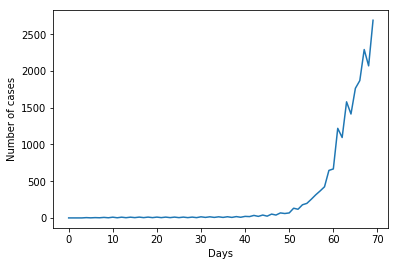

In [136]:
days = []
cases = []
i = 0
for loc, num_cases in zip(df_final[0]['Location'],df_final[0]['Num_Cases']):
    days.append(i)
    cases.append(num_cases)
    i += 1
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.plot(days, cases)

In [211]:
# df_India=df_India.set_index('Date')
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df_India = df_India[columns_input]
# input_data = df_India[columns_input]
# output_data = df_India['Num_Cases']
# X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.304761, random_state = 1)
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

print(df_India)
new_df = series_to_supervised(df_India,30,1,True)
new_df.drop(new_df.columns[[-2,-3,-4,-5]], axis=1, inplace=True)
new_df

    Population_Density  Min_Temp  Max_Temp  Lockdown  Num_Cases
0              0.30679  0.187500  0.312500       0.5   0.002920
1              0.30679  0.208333  0.333333       0.5   0.003411
2              0.30679  0.312500  0.333333       0.5   0.004890
3              0.30679  0.291667  0.312500       0.5   0.007468
4              0.30679  0.229167  0.291667       0.5   0.011008
5              0.30679  0.229167  0.270833       0.5   0.015284
6              0.30679  0.250000  0.375000       0.5   0.029329
7              0.30679  0.270833  0.416667       0.5   0.032404
8              0.30679  0.312500  0.520833       0.5   0.043369
9              0.30679  0.291667  0.479167       0.5   0.052226
10             0.30679  0.333333  0.458333       0.5   0.063372
11             0.30679  0.375000  0.458333       0.5   0.088655
12             0.30679  0.333333  0.479167       0.5   0.105130
13             0.30679  0.375000  0.520833       0.5   0.126414
14             0.30679  0.375000  0.5208

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var5(t-29),...,var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
30,0.30679,0.187500,0.312500,0.5,0.002920,0.30679,0.208333,0.333333,0.5,0.003411,...,0.333333,0.520833,0.5,0.397959,0.30679,0.395833,0.541667,0.5,0.400377,0.402902
31,0.30679,0.208333,0.333333,0.5,0.003411,0.30679,0.312500,0.333333,0.5,0.004890,...,0.395833,0.541667,0.5,0.400377,0.30679,0.416667,0.541667,0.5,0.402902,0.410643
32,0.30679,0.312500,0.333333,0.5,0.004890,0.30679,0.291667,0.312500,0.5,0.007468,...,0.416667,0.541667,0.5,0.402902,0.30679,0.458333,0.583333,0.5,0.410643,0.410728
33,0.30679,0.291667,0.312500,0.5,0.007468,0.30679,0.229167,0.291667,0.5,0.011008,...,0.458333,0.583333,0.5,0.410643,0.30679,0.437500,0.583333,0.5,0.410728,0.411871
34,0.30679,0.229167,0.291667,0.5,0.011008,0.30679,0.229167,0.270833,0.5,0.015284,...,0.437500,0.583333,0.5,0.410728,0.30679,0.479167,0.687500,0.5,0.411871,0.414582
35,0.30679,0.229167,0.270833,0.5,0.015284,0.30679,0.250000,0.375000,0.5,0.029329,...,0.479167,0.687500,0.5,0.411871,0.30679,0.500000,0.645833,0.5,0.414582,0.416745
36,0.30679,0.250000,0.375000,0.5,0.029329,0.30679,0.270833,0.416667,0.5,0.032404,...,0.500000,0.645833,0.5,0.414582,0.30679,0.458333,0.562500,0.5,0.416745,0.419056
37,0.30679,0.270833,0.416667,0.5,0.032404,0.30679,0.312500,0.520833,0.5,0.043369,...,0.458333,0.562500,0.5,0.416745,0.30679,0.312500,0.437500,0.5,0.419056,0.420796
38,0.30679,0.312500,0.520833,0.5,0.043369,0.30679,0.291667,0.479167,0.5,0.052226,...,0.312500,0.437500,0.5,0.419056,0.30679,0.208333,0.354167,0.5,0.420796,0.423076
39,0.30679,0.291667,0.479167,0.5,0.052226,0.30679,0.333333,0.458333,0.5,0.063372,...,0.208333,0.354167,0.5,0.420796,0.30679,0.354167,0.520833,0.5,0.423076,0.426145


In [137]:
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']

for i in range(len(df_final)):
    df_final[i] = df_final[i][columns_input]

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 2048)              16818176  
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 2049      
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 2         
Total params: 16,820,227
Trainable params: 16,820,227
Non-trainable params: 0
_________________________________________________________________
Train on 49 samples, validate on 47 samples
Epoch 1/10000
 - 9s - loss: 506440.1562 - val_loss: 682150.9375
Epoch 2/10000
 - 1s - loss: 506421.5000 - val_loss: 682128.0625
Epoch 3/10000
 - 1s - loss: 506402.7812 - val_loss: 682104.7500
Epoch 4/10000
 - 0s - loss: 506383.7188 - val_loss: 682081.0000
Epoch 5/10000
 - 0s - loss: 506364.2812 - val_loss: 682056.7500
Epoch 6

Epoch 115/10000
 - 0s - loss: 478512.1250 - val_loss: 647000.3125
Epoch 116/10000
 - 0s - loss: 477831.4375 - val_loss: 646145.6875
Epoch 117/10000
 - 0s - loss: 477140.9062 - val_loss: 645275.0625
Epoch 118/10000
 - 0s - loss: 476437.7188 - val_loss: 644392.0625
Epoch 119/10000
 - 0s - loss: 475724.8438 - val_loss: 643500.1875
Epoch 120/10000
 - 0s - loss: 475004.9688 - val_loss: 642595.9375
Epoch 121/10000
 - 0s - loss: 474275.4688 - val_loss: 641679.5000
Epoch 122/10000
 - 0s - loss: 473536.2812 - val_loss: 640750.7500
Epoch 123/10000
 - 0s - loss: 472787.5625 - val_loss: 639809.8750
Epoch 124/10000
 - 0s - loss: 472029.2188 - val_loss: 638853.2500
Epoch 125/10000
 - 0s - loss: 471258.5312 - val_loss: 637888.0000
Epoch 126/10000
 - 0s - loss: 470481.2500 - val_loss: 636910.9375
Epoch 127/10000
 - 0s - loss: 469694.6875 - val_loss: 635921.8125
Epoch 128/10000
 - 0s - loss: 468898.6875 - val_loss: 634917.0625
Epoch 129/10000
 - 0s - loss: 468090.6250 - val_loss: 633900.5000
Epoch 130/

 - 0s - loss: 358301.9688 - val_loss: 490377.3125
Epoch 240/10000
 - 0s - loss: 357476.5625 - val_loss: 489214.3750
Epoch 241/10000
 - 0s - loss: 356658.9375 - val_loss: 488060.0938
Epoch 242/10000
 - 0s - loss: 355849.0938 - val_loss: 486914.5000
Epoch 243/10000
 - 0s - loss: 355046.9688 - val_loss: 485777.5625
Epoch 244/10000
 - 0s - loss: 354252.6250 - val_loss: 484649.4375
Epoch 245/10000
 - 0s - loss: 353466.0312 - val_loss: 483530.0312
Epoch 246/10000
 - 0s - loss: 352687.1562 - val_loss: 482419.5312
Epoch 247/10000
 - 0s - loss: 351915.9688 - val_loss: 481317.6875
Epoch 248/10000
 - 0s - loss: 351152.5000 - val_loss: 480224.7188
Epoch 249/10000
 - 0s - loss: 350396.6562 - val_loss: 479140.6250
Epoch 250/10000
 - 0s - loss: 349648.4375 - val_loss: 478063.4375
Epoch 251/10000
 - 0s - loss: 348906.5312 - val_loss: 476996.9375
Epoch 252/10000
 - 0s - loss: 348173.4375 - val_loss: 475939.2188
Epoch 253/10000
 - 0s - loss: 347447.7812 - val_loss: 474890.3750
Epoch 254/10000
 - 0s - lo

Epoch 364/10000
 - 0s - loss: 282976.0000 - val_loss: 385077.6562
Epoch 365/10000
 - 0s - loss: 282260.3750 - val_loss: 384198.4375
Epoch 366/10000
 - 0s - loss: 281539.8438 - val_loss: 383313.4375
Epoch 367/10000
 - 0s - loss: 280813.5312 - val_loss: 382422.5625
Epoch 368/10000
 - 0s - loss: 280081.4688 - val_loss: 381525.6875
Epoch 369/10000
 - 0s - loss: 279343.5625 - val_loss: 380621.9062
Epoch 370/10000
 - 0s - loss: 278599.0312 - val_loss: 379712.9688
Epoch 371/10000
 - 0s - loss: 277849.4062 - val_loss: 378797.9062
Epoch 372/10000
 - 0s - loss: 277093.9062 - val_loss: 377875.6250
Epoch 373/10000
 - 0s - loss: 276331.6562 - val_loss: 376948.1562
Epoch 374/10000
 - 0s - loss: 275564.3125 - val_loss: 376014.3125
Epoch 375/10000
 - 0s - loss: 274791.0625 - val_loss: 375074.0938
Epoch 376/10000
 - 0s - loss: 274011.7500 - val_loss: 374126.4688
Epoch 377/10000
 - 0s - loss: 273225.6250 - val_loss: 373173.4062
Epoch 378/10000
 - 0s - loss: 272434.3750 - val_loss: 372213.7812
Epoch 379/

 - 0s - loss: 158310.1406 - val_loss: 232254.0469
Epoch 489/10000
 - 0s - loss: 157220.6406 - val_loss: 230858.3125
Epoch 490/10000
 - 0s - loss: 156134.5469 - val_loss: 229465.4844
Epoch 491/10000
 - 0s - loss: 155051.9844 - val_loss: 228075.6875
Epoch 492/10000
 - 0s - loss: 153973.0469 - val_loss: 226690.2188
Epoch 493/10000
 - 0s - loss: 152898.7344 - val_loss: 225308.0469
Epoch 494/10000
 - 0s - loss: 151828.2344 - val_loss: 223929.3125
Epoch 495/10000
 - 0s - loss: 150761.6250 - val_loss: 222554.2500
Epoch 496/10000
 - 0s - loss: 149699.1094 - val_loss: 221181.9219
Epoch 497/10000
 - 0s - loss: 148639.8438 - val_loss: 219814.5312
Epoch 498/10000
 - 0s - loss: 147585.6250 - val_loss: 218450.1875
Epoch 499/10000
 - 0s - loss: 146534.9531 - val_loss: 217091.0469
Epoch 500/10000
 - 0s - loss: 145489.4531 - val_loss: 215735.1875
Epoch 501/10000
 - 0s - loss: 144447.6250 - val_loss: 214383.7812
Epoch 502/10000
 - 0s - loss: 143410.3750 - val_loss: 213037.0000
Epoch 503/10000
 - 0s - lo

Epoch 614/10000
 - 0s - loss: 65614.8750 - val_loss: 106603.0625
Epoch 615/10000
 - 0s - loss: 65262.2500 - val_loss: 106070.7891
Epoch 616/10000
 - 0s - loss: 64914.3789 - val_loss: 105545.2422
Epoch 617/10000
 - 0s - loss: 64571.6719 - val_loss: 105025.7656
Epoch 618/10000
 - 0s - loss: 64233.6797 - val_loss: 104512.5938
Epoch 619/10000
 - 0s - loss: 63900.5312 - val_loss: 104006.0234
Epoch 620/10000
 - 0s - loss: 63572.4219 - val_loss: 103505.3047
Epoch 621/10000
 - 0s - loss: 63248.8281 - val_loss: 103011.0859
Epoch 622/10000
 - 0s - loss: 62930.1641 - val_loss: 102522.9688
Epoch 623/10000
 - 0s - loss: 62616.1680 - val_loss: 102040.9141
Epoch 624/10000
 - 0s - loss: 62306.8047 - val_loss: 101564.8906
Epoch 625/10000
 - 0s - loss: 62002.0391 - val_loss: 101094.8516
Epoch 626/10000
 - 0s - loss: 61701.7969 - val_loss: 100630.7031
Epoch 627/10000
 - 0s - loss: 61406.0625 - val_loss: 100172.4062
Epoch 628/10000
 - 0s - loss: 61114.7461 - val_loss: 99719.9375
Epoch 629/10000
 - 0s - lo

Epoch 742/10000
 - 0s - loss: 46740.5703 - val_loss: 74246.0391
Epoch 743/10000
 - 0s - loss: 46707.1289 - val_loss: 74163.4766
Epoch 744/10000
 - 0s - loss: 46674.3867 - val_loss: 74082.2109
Epoch 745/10000
 - 0s - loss: 46642.3164 - val_loss: 74002.1719
Epoch 746/10000
 - 0s - loss: 46610.9219 - val_loss: 73923.4219
Epoch 747/10000
 - 0s - loss: 46580.1992 - val_loss: 73845.9141
Epoch 748/10000
 - 0s - loss: 46550.1367 - val_loss: 73769.5781
Epoch 749/10000
 - 0s - loss: 46520.6992 - val_loss: 73694.4375
Epoch 750/10000
 - 0s - loss: 46491.8711 - val_loss: 73620.4922
Epoch 751/10000
 - 0s - loss: 46463.6797 - val_loss: 73547.6719
Epoch 752/10000
 - 0s - loss: 46436.0547 - val_loss: 73476.0078
Epoch 753/10000
 - 0s - loss: 46409.0391 - val_loss: 73405.4609
Epoch 754/10000
 - 0s - loss: 46382.5859 - val_loss: 73336.0391
Epoch 755/10000
 - 0s - loss: 46356.7109 - val_loss: 73267.6562
Epoch 756/10000
 - 0s - loss: 46331.3555 - val_loss: 73200.3594
Epoch 757/10000
 - 0s - loss: 46306.5469

 - 0s - loss: 45188.5625 - val_loss: 69585.7344
Epoch 871/10000
 - 0s - loss: 45184.8516 - val_loss: 69573.3125
Epoch 872/10000
 - 0s - loss: 45181.1797 - val_loss: 69561.0391
Epoch 873/10000
 - 0s - loss: 45177.5195 - val_loss: 69548.9375
Epoch 874/10000
 - 0s - loss: 45173.9023 - val_loss: 69537.0000
Epoch 875/10000
 - 0s - loss: 45170.3320 - val_loss: 69525.2188
Epoch 876/10000
 - 0s - loss: 45166.7695 - val_loss: 69513.5859
Epoch 877/10000
 - 0s - loss: 45163.2461 - val_loss: 69502.1250
Epoch 878/10000
 - 0s - loss: 45159.7461 - val_loss: 69490.7734
Epoch 879/10000
 - 0s - loss: 45156.2695 - val_loss: 69479.6016
Epoch 880/10000
 - 0s - loss: 45152.8438 - val_loss: 69468.5547
Epoch 881/10000
 - 0s - loss: 45149.4062 - val_loss: 69457.6562
Epoch 882/10000
 - 0s - loss: 45146.0039 - val_loss: 69446.8906
Epoch 883/10000
 - 0s - loss: 45142.6445 - val_loss: 69436.2734
Epoch 884/10000
 - 0s - loss: 45139.2891 - val_loss: 69425.7969
Epoch 885/10000
 - 0s - loss: 45135.9727 - val_loss: 694

Epoch 999/10000
 - 0s - loss: 44832.8281 - val_loss: 68760.6562
Epoch 1000/10000
 - 0s - loss: 44830.5352 - val_loss: 68757.5391
Epoch 1001/10000
 - 0s - loss: 44828.2188 - val_loss: 68754.4219
Epoch 1002/10000
 - 0s - loss: 44825.9141 - val_loss: 68751.3203
Epoch 1003/10000
 - 0s - loss: 44823.6016 - val_loss: 68748.2734
Epoch 1004/10000
 - 0s - loss: 44821.3164 - val_loss: 68745.2422
Epoch 1005/10000
 - 0s - loss: 44819.0195 - val_loss: 68742.2344
Epoch 1006/10000
 - 0s - loss: 44816.7227 - val_loss: 68739.2266
Epoch 1007/10000
 - 0s - loss: 44814.4297 - val_loss: 68736.2734
Epoch 1008/10000
 - 0s - loss: 44812.1445 - val_loss: 68733.2969
Epoch 1009/10000
 - 0s - loss: 44809.8516 - val_loss: 68730.3750
Epoch 1010/10000
 - 0s - loss: 44807.5703 - val_loss: 68727.4688
Epoch 1011/10000
 - 0s - loss: 44805.3125 - val_loss: 68724.6172
Epoch 1012/10000
 - 0s - loss: 44803.0469 - val_loss: 68721.7344
Epoch 1013/10000
 - 0s - loss: 44800.7773 - val_loss: 68718.8828
Epoch 1014/10000
 - 0s - l

 - 0s - loss: 44566.6875 - val_loss: 68480.2344
Epoch 1126/10000
 - 0s - loss: 44564.7539 - val_loss: 68478.5781
Epoch 1127/10000
 - 0s - loss: 44562.8477 - val_loss: 68476.8750
Epoch 1128/10000
 - 0s - loss: 44560.9219 - val_loss: 68475.1953
Epoch 1129/10000
 - 0s - loss: 44559.0000 - val_loss: 68473.5391
Epoch 1130/10000
 - 0s - loss: 44557.0977 - val_loss: 68471.8828
Epoch 1131/10000
 - 0s - loss: 44555.1875 - val_loss: 68470.2188
Epoch 1132/10000
 - 0s - loss: 44553.2812 - val_loss: 68468.5625
Epoch 1133/10000
 - 0s - loss: 44551.3867 - val_loss: 68466.8906
Epoch 1134/10000
 - 0s - loss: 44549.4688 - val_loss: 68465.2734
Epoch 1135/10000
 - 0s - loss: 44547.5820 - val_loss: 68463.6250
Epoch 1136/10000
 - 0s - loss: 44545.6953 - val_loss: 68461.9766
Epoch 1137/10000
 - 0s - loss: 44543.7969 - val_loss: 68460.3516
Epoch 1138/10000
 - 0s - loss: 44541.9023 - val_loss: 68458.7422
Epoch 1139/10000
 - 0s - loss: 44540.0195 - val_loss: 68457.1094
Epoch 1140/10000
 - 0s - loss: 44538.1328 

Epoch 1252/10000
 - 0s - loss: 44343.9453 - val_loss: 68295.5547
Epoch 1253/10000
 - 0s - loss: 44342.3516 - val_loss: 68294.2578
Epoch 1254/10000
 - 0s - loss: 44340.7500 - val_loss: 68293.0078
Epoch 1255/10000
 - 0s - loss: 44339.1719 - val_loss: 68291.7422
Epoch 1256/10000
 - 0s - loss: 44337.5938 - val_loss: 68290.4531
Epoch 1257/10000
 - 0s - loss: 44336.0000 - val_loss: 68289.2109
Epoch 1258/10000
 - 0s - loss: 44334.4375 - val_loss: 68287.9219
Epoch 1259/10000
 - 0s - loss: 44332.8359 - val_loss: 68286.6719
Epoch 1260/10000
 - 0s - loss: 44331.2773 - val_loss: 68285.4219
Epoch 1261/10000
 - 0s - loss: 44329.7109 - val_loss: 68284.1562
Epoch 1262/10000
 - 0s - loss: 44328.1445 - val_loss: 68282.9062
Epoch 1263/10000
 - 0s - loss: 44326.5781 - val_loss: 68281.6406
Epoch 1264/10000
 - 0s - loss: 44325.0000 - val_loss: 68280.4141
Epoch 1265/10000
 - 0s - loss: 44323.4648 - val_loss: 68279.1562
Epoch 1266/10000
 - 0s - loss: 44321.8945 - val_loss: 68277.9141
Epoch 1267/10000
 - 0s - 

 - 0s - loss: 44161.7773 - val_loss: 68151.4766
Epoch 1379/10000
 - 0s - loss: 44160.4727 - val_loss: 68150.4531
Epoch 1380/10000
 - 0s - loss: 44159.1680 - val_loss: 68149.4141
Epoch 1381/10000
 - 0s - loss: 44157.8555 - val_loss: 68148.4062
Epoch 1382/10000
 - 0s - loss: 44156.5625 - val_loss: 68147.3906
Epoch 1383/10000
 - 0s - loss: 44155.2656 - val_loss: 68146.3750
Epoch 1384/10000
 - 0s - loss: 44153.9688 - val_loss: 68145.3438
Epoch 1385/10000
 - 0s - loss: 44152.6641 - val_loss: 68144.3281
Epoch 1386/10000
 - 0s - loss: 44151.3711 - val_loss: 68143.3516
Epoch 1387/10000
 - 0s - loss: 44150.1016 - val_loss: 68142.3125
Epoch 1388/10000
 - 0s - loss: 44148.8047 - val_loss: 68141.3203
Epoch 1389/10000
 - 0s - loss: 44147.5312 - val_loss: 68140.3203
Epoch 1390/10000
 - 0s - loss: 44146.2500 - val_loss: 68139.3047
Epoch 1391/10000
 - 0s - loss: 44144.9492 - val_loss: 68138.2969
Epoch 1392/10000
 - 0s - loss: 44143.6797 - val_loss: 68137.2891
Epoch 1393/10000
 - 0s - loss: 44142.3945 

Epoch 1505/10000
 - 0s - loss: 44011.6133 - val_loss: 68034.3438
Epoch 1506/10000
 - 0s - loss: 44010.5469 - val_loss: 68033.5234
Epoch 1507/10000
 - 0s - loss: 44009.4844 - val_loss: 68032.7031
Epoch 1508/10000
 - 0s - loss: 44008.4336 - val_loss: 68031.8750
Epoch 1509/10000
 - 0s - loss: 44007.3711 - val_loss: 68031.0391
Epoch 1510/10000
 - 0s - loss: 44006.3125 - val_loss: 68030.2422
Epoch 1511/10000
 - 0s - loss: 44005.2656 - val_loss: 68029.4219
Epoch 1512/10000
 - 0s - loss: 44004.1992 - val_loss: 68028.6094
Epoch 1513/10000
 - 0s - loss: 44003.1562 - val_loss: 68027.7891
Epoch 1514/10000
 - 0s - loss: 44002.1055 - val_loss: 68026.9609
Epoch 1515/10000
 - 0s - loss: 44001.0391 - val_loss: 68026.1562
Epoch 1516/10000
 - 0s - loss: 44000.0039 - val_loss: 68025.3203
Epoch 1517/10000
 - 0s - loss: 43998.9492 - val_loss: 68024.5391
Epoch 1518/10000
 - 0s - loss: 43997.9297 - val_loss: 68023.7109
Epoch 1519/10000
 - 0s - loss: 43996.8672 - val_loss: 68022.9141
Epoch 1520/10000
 - 0s - 

 - 0s - loss: 43890.7148 - val_loss: 67940.6250
Epoch 1632/10000
 - 0s - loss: 43889.8516 - val_loss: 67939.9375
Epoch 1633/10000
 - 0s - loss: 43888.9844 - val_loss: 67939.2891
Epoch 1634/10000
 - 0s - loss: 43888.1328 - val_loss: 67938.6172
Epoch 1635/10000
 - 0s - loss: 43887.2812 - val_loss: 67937.9609
Epoch 1636/10000
 - 0s - loss: 43886.4297 - val_loss: 67937.3047
Epoch 1637/10000
 - 0s - loss: 43885.5703 - val_loss: 67936.6406
Epoch 1638/10000
 - 0s - loss: 43884.7188 - val_loss: 67935.9844
Epoch 1639/10000
 - 0s - loss: 43883.8711 - val_loss: 67935.3281
Epoch 1640/10000
 - 0s - loss: 43883.0195 - val_loss: 67934.6562
Epoch 1641/10000
 - 0s - loss: 43882.1836 - val_loss: 67934.0078
Epoch 1642/10000
 - 0s - loss: 43881.3359 - val_loss: 67933.3594
Epoch 1643/10000
 - 0s - loss: 43880.4883 - val_loss: 67932.7031
Epoch 1644/10000
 - 0s - loss: 43879.6484 - val_loss: 67932.0391
Epoch 1645/10000
 - 0s - loss: 43878.8047 - val_loss: 67931.4219
Epoch 1646/10000
 - 0s - loss: 43877.9727 

Epoch 1758/10000
 - 0s - loss: 43792.6953 - val_loss: 67864.8594
Epoch 1759/10000
 - 0s - loss: 43792.0039 - val_loss: 67864.3203
Epoch 1760/10000
 - 0s - loss: 43791.3203 - val_loss: 67863.7891
Epoch 1761/10000
 - 0s - loss: 43790.6328 - val_loss: 67863.2422
Epoch 1762/10000
 - 0s - loss: 43789.9492 - val_loss: 67862.7266
Epoch 1763/10000
 - 0s - loss: 43789.2656 - val_loss: 67862.2031
Epoch 1764/10000
 - 0s - loss: 43788.5820 - val_loss: 67861.6797
Epoch 1765/10000
 - 0s - loss: 43787.9062 - val_loss: 67861.1406
Epoch 1766/10000
 - 0s - loss: 43787.2305 - val_loss: 67860.5938
Epoch 1767/10000
 - 0s - loss: 43786.5352 - val_loss: 67860.0859
Epoch 1768/10000
 - 0s - loss: 43785.8711 - val_loss: 67859.5625
Epoch 1769/10000
 - 0s - loss: 43785.1953 - val_loss: 67859.0391
Epoch 1770/10000
 - 0s - loss: 43784.5273 - val_loss: 67858.5312
Epoch 1771/10000
 - 0s - loss: 43783.8633 - val_loss: 67858.0078
Epoch 1772/10000
 - 0s - loss: 43783.1875 - val_loss: 67857.4922
Epoch 1773/10000
 - 0s - 

 - 0s - loss: 43715.3008 - val_loss: 67804.5781
Epoch 1885/10000
 - 0s - loss: 43714.7539 - val_loss: 67804.1641
Epoch 1886/10000
 - 0s - loss: 43714.2148 - val_loss: 67803.7266
Epoch 1887/10000
 - 0s - loss: 43713.6562 - val_loss: 67803.3047
Epoch 1888/10000
 - 0s - loss: 43713.1172 - val_loss: 67802.8906
Epoch 1889/10000
 - 1s - loss: 43712.5859 - val_loss: 67802.4766
Epoch 1890/10000
 - 0s - loss: 43712.0469 - val_loss: 67802.0547
Epoch 1891/10000
 - 0s - loss: 43711.5117 - val_loss: 67801.6406
Epoch 1892/10000
 - 0s - loss: 43710.9727 - val_loss: 67801.2109
Epoch 1893/10000
 - 0s - loss: 43710.4336 - val_loss: 67800.8047
Epoch 1894/10000
 - 0s - loss: 43709.9023 - val_loss: 67800.3750
Epoch 1895/10000
 - 0s - loss: 43709.3672 - val_loss: 67799.9766
Epoch 1896/10000
 - 0s - loss: 43708.8359 - val_loss: 67799.5547
Epoch 1897/10000
 - 0s - loss: 43708.2969 - val_loss: 67799.1406
Epoch 1898/10000
 - 0s - loss: 43707.7656 - val_loss: 67798.7578
Epoch 1899/10000
 - 0s - loss: 43707.2539 

Epoch 2011/10000
 - 0s - loss: 43653.9375 - val_loss: 67756.4141
Epoch 2012/10000
 - 0s - loss: 43653.5195 - val_loss: 67756.0859
Epoch 2013/10000
 - 0s - loss: 43653.0938 - val_loss: 67755.7422
Epoch 2014/10000
 - 0s - loss: 43652.6680 - val_loss: 67755.4141
Epoch 2015/10000
 - 0s - loss: 43652.2500 - val_loss: 67755.0859
Epoch 2016/10000
 - 0s - loss: 43651.8203 - val_loss: 67754.7734
Epoch 2017/10000
 - 0s - loss: 43651.4062 - val_loss: 67754.4297
Epoch 2018/10000
 - 0s - loss: 43650.9844 - val_loss: 67754.0938
Epoch 2019/10000
 - 0s - loss: 43650.5547 - val_loss: 67753.7578
Epoch 2020/10000
 - 0s - loss: 43650.1367 - val_loss: 67753.4453
Epoch 2021/10000
 - 0s - loss: 43649.7383 - val_loss: 67753.1016
Epoch 2022/10000
 - 0s - loss: 43649.3125 - val_loss: 67752.7734
Epoch 2023/10000
 - 0s - loss: 43648.8867 - val_loss: 67752.4609
Epoch 2024/10000
 - 0s - loss: 43648.4844 - val_loss: 67752.1250
Epoch 2025/10000
 - 0s - loss: 43648.0703 - val_loss: 67751.8047
Epoch 2026/10000
 - 0s - 

 - 0s - loss: 43606.6523 - val_loss: 67718.7266
Epoch 2138/10000
 - 0s - loss: 43606.3203 - val_loss: 67718.4609
Epoch 2139/10000
 - 0s - loss: 43605.9883 - val_loss: 67718.2109
Epoch 2140/10000
 - 0s - loss: 43605.6719 - val_loss: 67717.9375
Epoch 2141/10000
 - 0s - loss: 43605.3477 - val_loss: 67717.6797
Epoch 2142/10000
 - 0s - loss: 43605.0273 - val_loss: 67717.4062
Epoch 2143/10000
 - 0s - loss: 43604.6953 - val_loss: 67717.1484
Epoch 2144/10000
 - 0s - loss: 43604.3711 - val_loss: 67716.8828
Epoch 2145/10000
 - 0s - loss: 43604.0508 - val_loss: 67716.6250
Epoch 2146/10000
 - 0s - loss: 43603.7188 - val_loss: 67716.3672
Epoch 2147/10000
 - 0s - loss: 43603.3984 - val_loss: 67716.1094
Epoch 2148/10000
 - 0s - loss: 43603.0820 - val_loss: 67715.8281
Epoch 2149/10000
 - 0s - loss: 43602.7539 - val_loss: 67715.5781
Epoch 2150/10000
 - 0s - loss: 43602.4336 - val_loss: 67715.3281
Epoch 2151/10000
 - 0s - loss: 43602.1172 - val_loss: 67715.0391
Epoch 2152/10000
 - 0s - loss: 43601.7891 

Epoch 2264/10000
 - 0s - loss: 43570.0273 - val_loss: 67688.7656
Epoch 2265/10000
 - 0s - loss: 43569.7891 - val_loss: 67688.5625
Epoch 2266/10000
 - 0s - loss: 43569.5391 - val_loss: 67688.3594
Epoch 2267/10000
 - 0s - loss: 43569.2891 - val_loss: 67688.1406
Epoch 2268/10000
 - 0s - loss: 43569.0352 - val_loss: 67687.9375
Epoch 2269/10000
 - 0s - loss: 43568.7969 - val_loss: 67687.7344
Epoch 2270/10000
 - 0s - loss: 43568.5508 - val_loss: 67687.5234
Epoch 2271/10000
 - 0s - loss: 43568.2891 - val_loss: 67687.3203
Epoch 2272/10000
 - 0s - loss: 43568.0547 - val_loss: 67687.1016
Epoch 2273/10000
 - 0s - loss: 43567.8008 - val_loss: 67686.9062
Epoch 2274/10000
 - 0s - loss: 43567.5508 - val_loss: 67686.7344
Epoch 2275/10000
 - 0s - loss: 43567.3320 - val_loss: 67686.5078
Epoch 2276/10000
 - 0s - loss: 43567.0664 - val_loss: 67686.3047
Epoch 2277/10000
 - 0s - loss: 43566.8203 - val_loss: 67686.1094
Epoch 2278/10000
 - 0s - loss: 43566.5938 - val_loss: 67685.9141
Epoch 2279/10000
 - 0s - 

 - 0s - loss: 43542.3359 - val_loss: 67665.3359
Epoch 2391/10000
 - 0s - loss: 43542.1367 - val_loss: 67665.1953
Epoch 2392/10000
 - 0s - loss: 43541.9531 - val_loss: 67665.0234
Epoch 2393/10000
 - 0s - loss: 43541.7812 - val_loss: 67664.8438
Epoch 2394/10000
 - 0s - loss: 43541.5859 - val_loss: 67664.6797
Epoch 2395/10000
 - 0s - loss: 43541.3867 - val_loss: 67664.5156
Epoch 2396/10000
 - 0s - loss: 43541.2031 - val_loss: 67664.3438
Epoch 2397/10000
 - 0s - loss: 43541.0117 - val_loss: 67664.1797
Epoch 2398/10000
 - 0s - loss: 43540.8320 - val_loss: 67664.0234
Epoch 2399/10000
 - 0s - loss: 43540.6445 - val_loss: 67663.8516
Epoch 2400/10000
 - 0s - loss: 43540.4492 - val_loss: 67663.6875
Epoch 2401/10000
 - 0s - loss: 43540.2656 - val_loss: 67663.5234
Epoch 2402/10000
 - 0s - loss: 43540.0781 - val_loss: 67663.3594
Epoch 2403/10000
 - 0s - loss: 43539.8984 - val_loss: 67663.1875
Epoch 2404/10000
 - 0s - loss: 43539.6953 - val_loss: 67663.0234
Epoch 2405/10000
 - 0s - loss: 43539.5156 

Epoch 2517/10000
 - 0s - loss: 43521.0547 - val_loss: 67646.2109
Epoch 2518/10000
 - 0s - loss: 43520.9023 - val_loss: 67646.0859
Epoch 2519/10000
 - 0s - loss: 43520.7617 - val_loss: 67645.9453
Epoch 2520/10000
 - 0s - loss: 43520.6211 - val_loss: 67645.8203
Epoch 2521/10000
 - 0s - loss: 43520.4688 - val_loss: 67645.6953
Epoch 2522/10000
 - 0s - loss: 43520.3203 - val_loss: 67645.5391
Epoch 2523/10000
 - 0s - loss: 43520.1641 - val_loss: 67645.4453
Epoch 2524/10000
 - 0s - loss: 43520.0508 - val_loss: 67645.2891
Epoch 2525/10000
 - 0s - loss: 43519.8945 - val_loss: 67645.1484
Epoch 2526/10000
 - 0s - loss: 43519.7461 - val_loss: 67645.0312
Epoch 2527/10000
 - 0s - loss: 43519.6133 - val_loss: 67644.8984
Epoch 2528/10000
 - 0s - loss: 43519.4648 - val_loss: 67644.7656
Epoch 2529/10000
 - 0s - loss: 43519.3164 - val_loss: 67644.6406
Epoch 2530/10000
 - 0s - loss: 43519.1875 - val_loss: 67644.5000
Epoch 2531/10000
 - 0s - loss: 43519.0352 - val_loss: 67644.3750
Epoch 2532/10000
 - 0s - 

 - 0s - loss: 43504.7617 - val_loss: 67630.4609
Epoch 2644/10000
 - 0s - loss: 43504.6484 - val_loss: 67630.3438
Epoch 2645/10000
 - 0s - loss: 43504.5352 - val_loss: 67630.2266
Epoch 2646/10000
 - 0s - loss: 43504.4219 - val_loss: 67630.0859
Epoch 2647/10000
 - 0s - loss: 43504.3047 - val_loss: 67629.9922
Epoch 2648/10000
 - 0s - loss: 43504.1953 - val_loss: 67629.8516
Epoch 2649/10000
 - 0s - loss: 43504.0664 - val_loss: 67629.7578
Epoch 2650/10000
 - 0s - loss: 43503.9688 - val_loss: 67629.6250
Epoch 2651/10000
 - 0s - loss: 43503.8477 - val_loss: 67629.5234
Epoch 2652/10000
 - 0s - loss: 43503.7344 - val_loss: 67629.4062
Epoch 2653/10000
 - 0s - loss: 43503.6328 - val_loss: 67629.2734
Epoch 2654/10000
 - 0s - loss: 43503.5117 - val_loss: 67629.1406
Epoch 2655/10000
 - 0s - loss: 43503.3867 - val_loss: 67629.0391
Epoch 2656/10000
 - 0s - loss: 43503.2969 - val_loss: 67628.9375
Epoch 2657/10000
 - 0s - loss: 43503.1836 - val_loss: 67628.8203
Epoch 2658/10000
 - 1s - loss: 43503.0703 

Epoch 2770/10000
 - 0s - loss: 43491.7344 - val_loss: 67616.3438
Epoch 2771/10000
 - 0s - loss: 43491.6289 - val_loss: 67616.2500
Epoch 2772/10000
 - 0s - loss: 43491.5312 - val_loss: 67616.1484
Epoch 2773/10000
 - 0s - loss: 43491.4453 - val_loss: 67616.0312
Epoch 2774/10000
 - 0s - loss: 43491.3516 - val_loss: 67615.9297
Epoch 2775/10000
 - 0s - loss: 43491.2617 - val_loss: 67615.8438
Epoch 2776/10000
 - 0s - loss: 43491.1875 - val_loss: 67615.7266
Epoch 2777/10000
 - 0s - loss: 43491.0977 - val_loss: 67615.5859
Epoch 2778/10000
 - 0s - loss: 43490.9688 - val_loss: 67615.5000
Epoch 2779/10000
 - 0s - loss: 43490.9023 - val_loss: 67615.4062
Epoch 2780/10000
 - 0s - loss: 43490.8320 - val_loss: 67615.2656
Epoch 2781/10000
 - 0s - loss: 43490.7109 - val_loss: 67615.1953
Epoch 2782/10000
 - 0s - loss: 43490.6289 - val_loss: 67615.0859
Epoch 2783/10000
 - 0s - loss: 43490.5352 - val_loss: 67614.9688
Epoch 2784/10000
 - 0s - loss: 43490.4453 - val_loss: 67614.8594
Epoch 2785/10000
 - 0s - 

 - 0s - loss: 43480.9961 - val_loss: 67603.2891
Epoch 2897/10000
 - 0s - loss: 43480.9336 - val_loss: 67603.1953
Epoch 2898/10000
 - 0s - loss: 43480.8477 - val_loss: 67603.0859
Epoch 2899/10000
 - 0s - loss: 43480.7617 - val_loss: 67602.9922
Epoch 2900/10000
 - 0s - loss: 43480.6875 - val_loss: 67602.8750
Epoch 2901/10000
 - 0s - loss: 43480.6172 - val_loss: 67602.7734
Epoch 2902/10000
 - 0s - loss: 43480.5273 - val_loss: 67602.6641
Epoch 2903/10000
 - 0s - loss: 43480.4531 - val_loss: 67602.5625
Epoch 2904/10000
 - 0s - loss: 43480.3672 - val_loss: 67602.4609
Epoch 2905/10000
 - 0s - loss: 43480.2891 - val_loss: 67602.3750
Epoch 2906/10000
 - 0s - loss: 43480.2188 - val_loss: 67602.2656
Epoch 2907/10000
 - 0s - loss: 43480.1445 - val_loss: 67602.1641
Epoch 2908/10000
 - 0s - loss: 43480.0664 - val_loss: 67602.0547
Epoch 2909/10000
 - 0s - loss: 43479.9883 - val_loss: 67601.9609
Epoch 2910/10000
 - 0s - loss: 43479.9141 - val_loss: 67601.8438
Epoch 2911/10000
 - 0s - loss: 43479.8320 

Epoch 3023/10000
 - 0s - loss: 43471.5195 - val_loss: 67590.2891
Epoch 3024/10000
 - 0s - loss: 43471.4531 - val_loss: 67590.1797
Epoch 3025/10000
 - 0s - loss: 43471.3789 - val_loss: 67590.0938
Epoch 3026/10000
 - 0s - loss: 43471.3125 - val_loss: 67589.9922
Epoch 3027/10000
 - 0s - loss: 43471.2461 - val_loss: 67589.8750
Epoch 3028/10000
 - 0s - loss: 43471.1641 - val_loss: 67589.7734
Epoch 3029/10000
 - 0s - loss: 43471.0938 - val_loss: 67589.6562
Epoch 3030/10000
 - 0s - loss: 43471.0312 - val_loss: 67589.5469
Epoch 3031/10000
 - 0s - loss: 43470.9492 - val_loss: 67589.4453
Epoch 3032/10000
 - 0s - loss: 43470.8828 - val_loss: 67589.3516
Epoch 3033/10000
 - 0s - loss: 43470.8125 - val_loss: 67589.2422
Epoch 3034/10000
 - 0s - loss: 43470.7344 - val_loss: 67589.1406
Epoch 3035/10000
 - 0s - loss: 43470.6680 - val_loss: 67589.0391
Epoch 3036/10000
 - 0s - loss: 43470.5977 - val_loss: 67588.9375
Epoch 3037/10000
 - 0s - loss: 43470.5352 - val_loss: 67588.8281
Epoch 3038/10000
 - 0s - 

 - 0s - loss: 43462.7656 - val_loss: 67576.8516
Epoch 3150/10000
 - 0s - loss: 43462.7031 - val_loss: 67576.7422
Epoch 3151/10000
 - 0s - loss: 43462.6328 - val_loss: 67576.6484
Epoch 3152/10000
 - 0s - loss: 43462.5664 - val_loss: 67576.5234
Epoch 3153/10000
 - 0s - loss: 43462.5000 - val_loss: 67576.4219
Epoch 3154/10000
 - 0s - loss: 43462.4453 - val_loss: 67576.3125
Epoch 3155/10000
 - 0s - loss: 43462.3672 - val_loss: 67576.2031
Epoch 3156/10000
 - 0s - loss: 43462.2969 - val_loss: 67576.0938
Epoch 3157/10000
 - 0s - loss: 43462.2344 - val_loss: 67575.9844
Epoch 3158/10000
 - 0s - loss: 43462.1562 - val_loss: 67575.8750
Epoch 3159/10000
 - 0s - loss: 43462.0820 - val_loss: 67575.7500
Epoch 3160/10000
 - 0s - loss: 43462.0156 - val_loss: 67575.6484
Epoch 3161/10000
 - 0s - loss: 43461.9609 - val_loss: 67575.5391
Epoch 3162/10000
 - 0s - loss: 43461.8828 - val_loss: 67575.4062
Epoch 3163/10000
 - 0s - loss: 43461.8008 - val_loss: 67575.3047
Epoch 3164/10000
 - 0s - loss: 43461.7500 

Epoch 3276/10000
 - 0s - loss: 43454.1367 - val_loss: 67562.5000
Epoch 3277/10000
 - 0s - loss: 43454.0508 - val_loss: 67562.3750
Epoch 3278/10000
 - 0s - loss: 43453.9805 - val_loss: 67562.2734
Epoch 3279/10000
 - 0s - loss: 43453.9219 - val_loss: 67562.1484
Epoch 3280/10000
 - 0s - loss: 43453.8555 - val_loss: 67562.0547
Epoch 3281/10000
 - 0s - loss: 43453.7969 - val_loss: 67561.9219
Epoch 3282/10000
 - 0s - loss: 43453.7148 - val_loss: 67561.8203
Epoch 3283/10000
 - 0s - loss: 43453.6641 - val_loss: 67561.6797
Epoch 3284/10000
 - 0s - loss: 43453.5820 - val_loss: 67561.5547
Epoch 3285/10000
 - 0s - loss: 43453.5039 - val_loss: 67561.4375
Epoch 3286/10000
 - 0s - loss: 43453.4336 - val_loss: 67561.3203
Epoch 3287/10000
 - 0s - loss: 43453.3672 - val_loss: 67561.2109
Epoch 3288/10000
 - 0s - loss: 43453.3047 - val_loss: 67561.0938
Epoch 3289/10000
 - 0s - loss: 43453.2383 - val_loss: 67560.9766
Epoch 3290/10000
 - 0s - loss: 43453.1719 - val_loss: 67560.8750
Epoch 3291/10000
 - 0s - 

 - 0s - loss: 43445.3984 - val_loss: 67547.0859
Epoch 3403/10000
 - 0s - loss: 43445.3516 - val_loss: 67546.9453
Epoch 3404/10000
 - 0s - loss: 43445.2812 - val_loss: 67546.8281
Epoch 3405/10000
 - 0s - loss: 43445.2031 - val_loss: 67546.6953
Epoch 3406/10000
 - 0s - loss: 43445.1367 - val_loss: 67546.5703
Epoch 3407/10000
 - 0s - loss: 43445.0664 - val_loss: 67546.4453
Epoch 3408/10000
 - 0s - loss: 43444.9961 - val_loss: 67546.2969
Epoch 3409/10000
 - 0s - loss: 43444.9180 - val_loss: 67546.1953
Epoch 3410/10000
 - 0s - loss: 43444.8516 - val_loss: 67546.0312
Epoch 3411/10000
 - 0s - loss: 43444.7695 - val_loss: 67545.9219
Epoch 3412/10000
 - 0s - loss: 43444.7109 - val_loss: 67545.8047
Epoch 3413/10000
 - 0s - loss: 43444.6484 - val_loss: 67545.6719
Epoch 3414/10000
 - 0s - loss: 43444.5781 - val_loss: 67545.5469
Epoch 3415/10000
 - 0s - loss: 43444.5039 - val_loss: 67545.4375
Epoch 3416/10000
 - 0s - loss: 43444.4375 - val_loss: 67545.2891
Epoch 3417/10000
 - 0s - loss: 43444.3555 

Epoch 3529/10000
 - 0s - loss: 43436.2500 - val_loss: 67530.2266
Epoch 3530/10000
 - 0s - loss: 43436.1797 - val_loss: 67530.0781
Epoch 3531/10000
 - 0s - loss: 43436.1055 - val_loss: 67529.9609
Epoch 3532/10000
 - 1s - loss: 43436.0273 - val_loss: 67529.8203
Epoch 3533/10000
 - 0s - loss: 43435.9492 - val_loss: 67529.6719
Epoch 3534/10000
 - 0s - loss: 43435.8828 - val_loss: 67529.5625
Epoch 3535/10000
 - 0s - loss: 43435.8125 - val_loss: 67529.3828
Epoch 3536/10000
 - 0s - loss: 43435.7188 - val_loss: 67529.2656
Epoch 3537/10000
 - 0s - loss: 43435.6484 - val_loss: 67529.1250
Epoch 3538/10000
 - 0s - loss: 43435.5703 - val_loss: 67529.0000
Epoch 3539/10000
 - 0s - loss: 43435.5000 - val_loss: 67528.8438
Epoch 3540/10000
 - 0s - loss: 43435.4297 - val_loss: 67528.6953
Epoch 3541/10000
 - 0s - loss: 43435.3555 - val_loss: 67528.5391
Epoch 3542/10000
 - 0s - loss: 43435.2773 - val_loss: 67528.4062
Epoch 3543/10000
 - 0s - loss: 43435.2148 - val_loss: 67528.2656
Epoch 3544/10000
 - 0s - 

 - 0s - loss: 43426.6172 - val_loss: 67512.0000
Epoch 3656/10000
 - 0s - loss: 43426.5469 - val_loss: 67511.8516
Epoch 3657/10000
 - 0s - loss: 43426.4609 - val_loss: 67511.6797
Epoch 3658/10000
 - 0s - loss: 43426.3828 - val_loss: 67511.5234
Epoch 3659/10000
 - 0s - loss: 43426.2969 - val_loss: 67511.3750
Epoch 3660/10000
 - 0s - loss: 43426.2305 - val_loss: 67511.2500
Epoch 3661/10000
 - 0s - loss: 43426.1484 - val_loss: 67511.0859
Epoch 3662/10000
 - 0s - loss: 43426.0664 - val_loss: 67510.9375
Epoch 3663/10000
 - 0s - loss: 43425.9844 - val_loss: 67510.7969
Epoch 3664/10000
 - 0s - loss: 43425.9141 - val_loss: 67510.6484
Epoch 3665/10000
 - 0s - loss: 43425.8320 - val_loss: 67510.4922
Epoch 3666/10000
 - 0s - loss: 43425.7461 - val_loss: 67510.3281
Epoch 3667/10000
 - 0s - loss: 43425.6641 - val_loss: 67510.1875
Epoch 3668/10000
 - 0s - loss: 43425.5938 - val_loss: 67510.0312
Epoch 3669/10000
 - 0s - loss: 43425.5156 - val_loss: 67509.8906
Epoch 3670/10000
 - 0s - loss: 43425.4336 

Epoch 3782/10000
 - 0s - loss: 43416.2461 - val_loss: 67491.9609
Epoch 3783/10000
 - 0s - loss: 43416.1562 - val_loss: 67491.7891
Epoch 3784/10000
 - 0s - loss: 43416.0781 - val_loss: 67491.6406
Epoch 3785/10000
 - 0s - loss: 43415.9961 - val_loss: 67491.4844
Epoch 3786/10000
 - 0s - loss: 43415.9141 - val_loss: 67491.3047
Epoch 3787/10000
 - 0s - loss: 43415.8281 - val_loss: 67491.1484
Epoch 3788/10000
 - 0s - loss: 43415.7344 - val_loss: 67490.9766
Epoch 3789/10000
 - 0s - loss: 43415.6523 - val_loss: 67490.8047
Epoch 3790/10000
 - 0s - loss: 43415.5664 - val_loss: 67490.6719
Epoch 3791/10000
 - 0s - loss: 43415.4883 - val_loss: 67490.5000
Epoch 3792/10000
 - 0s - loss: 43415.4141 - val_loss: 67490.3281
Epoch 3793/10000
 - 0s - loss: 43415.3203 - val_loss: 67490.1719
Epoch 3794/10000
 - 0s - loss: 43415.2305 - val_loss: 67490.0000
Epoch 3795/10000
 - 0s - loss: 43415.1484 - val_loss: 67489.8203
Epoch 3796/10000
 - 0s - loss: 43415.0469 - val_loss: 67489.6797
Epoch 3797/10000
 - 0s - 

 - 0s - loss: 43405.2188 - val_loss: 67470.4219
Epoch 3909/10000
 - 0s - loss: 43405.1289 - val_loss: 67470.2578
Epoch 3910/10000
 - 0s - loss: 43405.0352 - val_loss: 67470.0547
Epoch 3911/10000
 - 0s - loss: 43404.9375 - val_loss: 67469.8750
Epoch 3912/10000
 - 0s - loss: 43404.8477 - val_loss: 67469.6953
Epoch 3913/10000
 - 0s - loss: 43404.7539 - val_loss: 67469.5312
Epoch 3914/10000
 - 0s - loss: 43404.6641 - val_loss: 67469.3438
Epoch 3915/10000
 - 0s - loss: 43404.5664 - val_loss: 67469.1719
Epoch 3916/10000
 - 0s - loss: 43404.4844 - val_loss: 67468.9766
Epoch 3917/10000
 - 0s - loss: 43404.3867 - val_loss: 67468.8047
Epoch 3918/10000
 - 0s - loss: 43404.2969 - val_loss: 67468.6172
Epoch 3919/10000
 - 0s - loss: 43404.1992 - val_loss: 67468.4453
Epoch 3920/10000
 - 0s - loss: 43404.1133 - val_loss: 67468.2578
Epoch 3921/10000
 - 0s - loss: 43404.0195 - val_loss: 67468.0781
Epoch 3922/10000
 - 0s - loss: 43403.9180 - val_loss: 67467.8906
Epoch 3923/10000
 - 0s - loss: 43403.8320 

Epoch 4035/10000
 - 0s - loss: 43393.2188 - val_loss: 67446.7578
Epoch 4036/10000
 - 0s - loss: 43393.1211 - val_loss: 67446.5703
Epoch 4037/10000
 - 0s - loss: 43393.0312 - val_loss: 67446.3906
Epoch 4038/10000
 - 0s - loss: 43392.9375 - val_loss: 67446.2109
Epoch 4039/10000
 - 0s - loss: 43392.8438 - val_loss: 67446.0000
Epoch 4040/10000
 - 0s - loss: 43392.7383 - val_loss: 67445.7969
Epoch 4041/10000
 - 0s - loss: 43392.6445 - val_loss: 67445.5938
Epoch 4042/10000
 - 0s - loss: 43392.5469 - val_loss: 67445.4141
Epoch 4043/10000
 - 0s - loss: 43392.4453 - val_loss: 67445.2266
Epoch 4044/10000
 - 0s - loss: 43392.3477 - val_loss: 67445.0156
Epoch 4045/10000
 - 0s - loss: 43392.2500 - val_loss: 67444.8203
Epoch 4046/10000
 - 0s - loss: 43392.1484 - val_loss: 67444.6250
Epoch 4047/10000
 - 0s - loss: 43392.0547 - val_loss: 67444.4297
Epoch 4048/10000
 - 0s - loss: 43391.9453 - val_loss: 67444.2578
Epoch 4049/10000
 - 0s - loss: 43391.8672 - val_loss: 67444.0391
Epoch 4050/10000
 - 0s - 

 - 0s - loss: 43380.3984 - val_loss: 67421.2969
Epoch 4162/10000
 - 0s - loss: 43380.3047 - val_loss: 67421.0781
Epoch 4163/10000
 - 0s - loss: 43380.1875 - val_loss: 67420.8594
Epoch 4164/10000
 - 0s - loss: 43380.0859 - val_loss: 67420.6484
Epoch 4165/10000
 - 0s - loss: 43379.9727 - val_loss: 67420.4609
Epoch 4166/10000
 - 0s - loss: 43379.8828 - val_loss: 67420.2500
Epoch 4167/10000
 - 0s - loss: 43379.7812 - val_loss: 67420.0391
Epoch 4168/10000
 - 0s - loss: 43379.6641 - val_loss: 67419.8203
Epoch 4169/10000
 - 0s - loss: 43379.5664 - val_loss: 67419.6172
Epoch 4170/10000
 - 0s - loss: 43379.4648 - val_loss: 67419.3984
Epoch 4171/10000
 - 0s - loss: 43379.3477 - val_loss: 67419.1953
Epoch 4172/10000
 - 0s - loss: 43379.2500 - val_loss: 67418.9922
Epoch 4173/10000
 - 0s - loss: 43379.1445 - val_loss: 67418.7656
Epoch 4174/10000
 - 0s - loss: 43379.0312 - val_loss: 67418.5547
Epoch 4175/10000
 - 0s - loss: 43378.9180 - val_loss: 67418.3438
Epoch 4176/10000
 - 0s - loss: 43378.8203 

Epoch 4288/10000
 - 0s - loss: 43366.4297 - val_loss: 67393.3750
Epoch 4289/10000
 - 0s - loss: 43366.3164 - val_loss: 67393.1406
Epoch 4290/10000
 - 0s - loss: 43366.2031 - val_loss: 67392.9375
Epoch 4291/10000
 - 0s - loss: 43366.1016 - val_loss: 67392.6875
Epoch 4292/10000
 - 0s - loss: 43365.9688 - val_loss: 67392.4766
Epoch 4293/10000
 - 0s - loss: 43365.8672 - val_loss: 67392.2266
Epoch 4294/10000
 - 0s - loss: 43365.7461 - val_loss: 67391.9766
Epoch 4295/10000
 - 0s - loss: 43365.6211 - val_loss: 67391.7578
Epoch 4296/10000
 - 0s - loss: 43365.5156 - val_loss: 67391.5391
Epoch 4297/10000
 - 0s - loss: 43365.4023 - val_loss: 67391.2891
Epoch 4298/10000
 - 0s - loss: 43365.2695 - val_loss: 67391.0938
Epoch 4299/10000
 - 0s - loss: 43365.1797 - val_loss: 67390.8594
Epoch 4300/10000
 - 0s - loss: 43365.0625 - val_loss: 67390.6406
Epoch 4301/10000
 - 0s - loss: 43364.9492 - val_loss: 67390.3984
Epoch 4302/10000
 - 0s - loss: 43364.8320 - val_loss: 67390.1641
Epoch 4303/10000
 - 0s - 

 - 0s - loss: 43351.4297 - val_loss: 67363.2266
Epoch 4415/10000
 - 0s - loss: 43351.2891 - val_loss: 67362.9844
Epoch 4416/10000
 - 0s - loss: 43351.1797 - val_loss: 67362.7344
Epoch 4417/10000
 - 0s - loss: 43351.0469 - val_loss: 67362.5000
Epoch 4418/10000
 - 0s - loss: 43350.9453 - val_loss: 67362.2344
Epoch 4419/10000
 - 0s - loss: 43350.8047 - val_loss: 67362.0078
Epoch 4420/10000
 - 0s - loss: 43350.7031 - val_loss: 67361.7266
Epoch 4421/10000
 - 0s - loss: 43350.5508 - val_loss: 67361.4922
Epoch 4422/10000
 - 0s - loss: 43350.4375 - val_loss: 67361.2344
Epoch 4423/10000
 - 0s - loss: 43350.3125 - val_loss: 67360.9766
Epoch 4424/10000
 - 0s - loss: 43350.1797 - val_loss: 67360.7344
Epoch 4425/10000
 - 0s - loss: 43350.0664 - val_loss: 67360.4688
Epoch 4426/10000
 - 0s - loss: 43349.9219 - val_loss: 67360.2109
Epoch 4427/10000
 - 0s - loss: 43349.8047 - val_loss: 67360.0000
Epoch 4428/10000
 - 0s - loss: 43349.6875 - val_loss: 67359.7109
Epoch 4429/10000
 - 0s - loss: 43349.5508 

Epoch 4541/10000
 - 0s - loss: 43335.0156 - val_loss: 67330.1094
Epoch 4542/10000
 - 0s - loss: 43334.8828 - val_loss: 67329.8438
Epoch 4543/10000
 - 0s - loss: 43334.7461 - val_loss: 67329.5859
Epoch 4544/10000
 - 0s - loss: 43334.6133 - val_loss: 67329.2969
Epoch 4545/10000
 - 0s - loss: 43334.4844 - val_loss: 67329.0312
Epoch 4546/10000
 - 0s - loss: 43334.3477 - val_loss: 67328.7578
Epoch 4547/10000
 - 0s - loss: 43334.2148 - val_loss: 67328.4766
Epoch 4548/10000
 - 0s - loss: 43334.0703 - val_loss: 67328.2109
Epoch 4549/10000
 - 0s - loss: 43333.9336 - val_loss: 67327.9375
Epoch 4550/10000
 - 0s - loss: 43333.7969 - val_loss: 67327.6562
Epoch 4551/10000
 - 0s - loss: 43333.6680 - val_loss: 67327.3828
Epoch 4552/10000
 - 0s - loss: 43333.5312 - val_loss: 67327.1172
Epoch 4553/10000
 - 0s - loss: 43333.3984 - val_loss: 67326.8438
Epoch 4554/10000
 - 0s - loss: 43333.2617 - val_loss: 67326.5547
Epoch 4555/10000
 - 0s - loss: 43333.1328 - val_loss: 67326.2969
Epoch 4556/10000
 - 0s - 

 - 0s - loss: 43317.3203 - val_loss: 67294.2344
Epoch 4668/10000
 - 0s - loss: 43317.1836 - val_loss: 67293.9141
Epoch 4669/10000
 - 0s - loss: 43317.0273 - val_loss: 67293.6406
Epoch 4670/10000
 - 0s - loss: 43316.8828 - val_loss: 67293.3516
Epoch 4671/10000
 - 0s - loss: 43316.7461 - val_loss: 67293.0391
Epoch 4672/10000
 - 0s - loss: 43316.5820 - val_loss: 67292.7344
Epoch 4673/10000
 - 0s - loss: 43316.4375 - val_loss: 67292.4453
Epoch 4674/10000
 - 0s - loss: 43316.2852 - val_loss: 67292.1484
Epoch 4675/10000
 - 0s - loss: 43316.1367 - val_loss: 67291.8594
Epoch 4676/10000
 - 0s - loss: 43316.0117 - val_loss: 67291.5391
Epoch 4677/10000
 - 0s - loss: 43315.8516 - val_loss: 67291.2344
Epoch 4678/10000
 - 0s - loss: 43315.6992 - val_loss: 67290.9375
Epoch 4679/10000
 - 0s - loss: 43315.5508 - val_loss: 67290.6406
Epoch 4680/10000
 - 0s - loss: 43315.4141 - val_loss: 67290.3438
Epoch 4681/10000
 - 0s - loss: 43315.2539 - val_loss: 67290.0391
Epoch 4682/10000
 - 0s - loss: 43315.1133 

Epoch 4794/10000
 - 0s - loss: 43297.8867 - val_loss: 67254.6250
Epoch 4795/10000
 - 0s - loss: 43297.7188 - val_loss: 67254.3047
Epoch 4796/10000
 - 0s - loss: 43297.5703 - val_loss: 67253.9609
Epoch 4797/10000
 - 0s - loss: 43297.3945 - val_loss: 67253.6562
Epoch 4798/10000
 - 0s - loss: 43297.2383 - val_loss: 67253.3438
Epoch 4799/10000
 - 0s - loss: 43297.0859 - val_loss: 67253.0000
Epoch 4800/10000
 - 0s - loss: 43296.9141 - val_loss: 67252.6719
Epoch 4801/10000
 - 0s - loss: 43296.7656 - val_loss: 67252.3281
Epoch 4802/10000
 - 0s - loss: 43296.5859 - val_loss: 67252.0156
Epoch 4803/10000
 - 0s - loss: 43296.4492 - val_loss: 67251.6953
Epoch 4804/10000
 - 0s - loss: 43296.2852 - val_loss: 67251.3438
Epoch 4805/10000
 - 0s - loss: 43296.1133 - val_loss: 67251.0234
Epoch 4806/10000
 - 0s - loss: 43295.9531 - val_loss: 67250.7031
Epoch 4807/10000
 - 0s - loss: 43295.7969 - val_loss: 67250.3750
Epoch 4808/10000
 - 0s - loss: 43295.6289 - val_loss: 67250.0391
Epoch 4809/10000
 - 0s - 

 - 0s - loss: 43276.8359 - val_loss: 67211.5234
Epoch 4921/10000
 - 0s - loss: 43276.6562 - val_loss: 67211.1406
Epoch 4922/10000
 - 0s - loss: 43276.4648 - val_loss: 67210.7969
Epoch 4923/10000
 - 0s - loss: 43276.3008 - val_loss: 67210.4219
Epoch 4924/10000
 - 0s - loss: 43276.1172 - val_loss: 67210.0781
Epoch 4925/10000
 - 0s - loss: 43275.9492 - val_loss: 67209.7109
Epoch 4926/10000
 - 0s - loss: 43275.7656 - val_loss: 67209.3594
Epoch 4927/10000
 - 0s - loss: 43275.5977 - val_loss: 67209.0000
Epoch 4928/10000
 - 0s - loss: 43275.4219 - val_loss: 67208.6328
Epoch 4929/10000
 - 0s - loss: 43275.2383 - val_loss: 67208.2734
Epoch 4930/10000
 - 0s - loss: 43275.0781 - val_loss: 67207.8984
Epoch 4931/10000
 - 0s - loss: 43274.8867 - val_loss: 67207.5547
Epoch 4932/10000
 - 0s - loss: 43274.7227 - val_loss: 67207.1875
Epoch 4933/10000
 - 0s - loss: 43274.5469 - val_loss: 67206.8125
Epoch 4934/10000
 - 0s - loss: 43274.3633 - val_loss: 67206.4688
Epoch 4935/10000
 - 0s - loss: 43274.1836 

Epoch 5047/10000
 - 0s - loss: 43253.5781 - val_loss: 67163.6797
Epoch 5048/10000
 - 0s - loss: 43253.3984 - val_loss: 67163.2734
Epoch 5049/10000
 - 0s - loss: 43253.1992 - val_loss: 67162.8750
Epoch 5050/10000
 - 0s - loss: 43253.0000 - val_loss: 67162.4688
Epoch 5051/10000
 - 0s - loss: 43252.8203 - val_loss: 67162.0781
Epoch 5052/10000
 - 0s - loss: 43252.6211 - val_loss: 67161.6797
Epoch 5053/10000
 - 0s - loss: 43252.4336 - val_loss: 67161.2891
Epoch 5054/10000
 - 0s - loss: 43252.2344 - val_loss: 67160.8984
Epoch 5055/10000
 - 0s - loss: 43252.0352 - val_loss: 67160.4766
Epoch 5056/10000
 - 0s - loss: 43251.8477 - val_loss: 67160.0859
Epoch 5057/10000
 - 0s - loss: 43251.6523 - val_loss: 67159.6797
Epoch 5058/10000
 - 0s - loss: 43251.4531 - val_loss: 67159.2969
Epoch 5059/10000
 - 0s - loss: 43251.2773 - val_loss: 67158.8906
Epoch 5060/10000
 - 0s - loss: 43251.0703 - val_loss: 67158.4922
Epoch 5061/10000
 - 0s - loss: 43250.8828 - val_loss: 67158.0938
Epoch 5062/10000
 - 0s - 

 - 0s - loss: 43228.2617 - val_loss: 67111.2266
Epoch 5174/10000
 - 0s - loss: 43228.0391 - val_loss: 67110.7734
Epoch 5175/10000
 - 0s - loss: 43227.8281 - val_loss: 67110.3438
Epoch 5176/10000
 - 0s - loss: 43227.6133 - val_loss: 67109.9141
Epoch 5177/10000
 - 0s - loss: 43227.4062 - val_loss: 67109.4688
Epoch 5178/10000
 - 0s - loss: 43227.1875 - val_loss: 67109.0234
Epoch 5179/10000
 - 0s - loss: 43226.9883 - val_loss: 67108.5938
Epoch 5180/10000
 - 0s - loss: 43226.7812 - val_loss: 67108.1562
Epoch 5181/10000
 - 0s - loss: 43226.5547 - val_loss: 67107.7109
Epoch 5182/10000
 - 0s - loss: 43226.3477 - val_loss: 67107.2734
Epoch 5183/10000
 - 0s - loss: 43226.1367 - val_loss: 67106.8281
Epoch 5184/10000
 - 0s - loss: 43225.9180 - val_loss: 67106.3984
Epoch 5185/10000
 - 0s - loss: 43225.7148 - val_loss: 67105.9609
Epoch 5186/10000
 - 0s - loss: 43225.5000 - val_loss: 67105.5000
Epoch 5187/10000
 - 0s - loss: 43225.2812 - val_loss: 67105.0781
Epoch 5188/10000
 - 0s - loss: 43225.0820 

Epoch 5300/10000
 - 0s - loss: 43200.1484 - val_loss: 67052.6562
Epoch 5301/10000
 - 0s - loss: 43199.9180 - val_loss: 67052.1484
Epoch 5302/10000
 - 0s - loss: 43199.6719 - val_loss: 67051.6797
Epoch 5303/10000
 - 0s - loss: 43199.4453 - val_loss: 67051.1953
Epoch 5304/10000
 - 0s - loss: 43199.2109 - val_loss: 67050.7031
Epoch 5305/10000
 - 0s - loss: 43198.9727 - val_loss: 67050.2109
Epoch 5306/10000
 - 0s - loss: 43198.7461 - val_loss: 67049.7344
Epoch 5307/10000
 - 0s - loss: 43198.5156 - val_loss: 67049.2344
Epoch 5308/10000
 - 0s - loss: 43198.2773 - val_loss: 67048.7578
Epoch 5309/10000
 - 0s - loss: 43198.0508 - val_loss: 67048.2734
Epoch 5310/10000
 - 0s - loss: 43197.8125 - val_loss: 67047.7578
Epoch 5311/10000
 - 0s - loss: 43197.5781 - val_loss: 67047.2734
Epoch 5312/10000
 - 0s - loss: 43197.3477 - val_loss: 67046.7891
Epoch 5313/10000
 - 0s - loss: 43197.1016 - val_loss: 67046.2891
Epoch 5314/10000
 - 0s - loss: 43196.8711 - val_loss: 67045.8047
Epoch 5315/10000
 - 0s - 

 - 0s - loss: 43169.3477 - val_loss: 66988.0234
Epoch 5427/10000
 - 0s - loss: 43169.0938 - val_loss: 66987.5000
Epoch 5428/10000
 - 0s - loss: 43168.8320 - val_loss: 66986.9453
Epoch 5429/10000
 - 0s - loss: 43168.5664 - val_loss: 66986.3828
Epoch 5430/10000
 - 0s - loss: 43168.3164 - val_loss: 66985.8750
Epoch 5431/10000
 - 0s - loss: 43168.0664 - val_loss: 66985.3203
Epoch 5432/10000
 - 0s - loss: 43167.8008 - val_loss: 66984.7656
Epoch 5433/10000
 - 0s - loss: 43167.5469 - val_loss: 66984.2266
Epoch 5434/10000
 - 0s - loss: 43167.2852 - val_loss: 66983.6875
Epoch 5435/10000
 - 0s - loss: 43167.0312 - val_loss: 66983.1406
Epoch 5436/10000
 - 0s - loss: 43166.7695 - val_loss: 66982.5859
Epoch 5437/10000
 - 0s - loss: 43166.5156 - val_loss: 66982.0391
Epoch 5438/10000
 - 0s - loss: 43166.2461 - val_loss: 66981.5000
Epoch 5439/10000
 - 0s - loss: 43165.9883 - val_loss: 66980.9375
Epoch 5440/10000
 - 0s - loss: 43165.7305 - val_loss: 66980.3828
Epoch 5441/10000
 - 0s - loss: 43165.4531 

Epoch 5553/10000
 - 0s - loss: 43134.9688 - val_loss: 66915.3359
Epoch 5554/10000
 - 0s - loss: 43134.6797 - val_loss: 66914.7266
Epoch 5555/10000
 - 0s - loss: 43134.4023 - val_loss: 66914.1094
Epoch 5556/10000
 - 0s - loss: 43134.1133 - val_loss: 66913.5234
Epoch 5557/10000
 - 0s - loss: 43133.8359 - val_loss: 66912.8984
Epoch 5558/10000
 - 0s - loss: 43133.5391 - val_loss: 66912.2734
Epoch 5559/10000
 - 0s - loss: 43133.2461 - val_loss: 66911.6953
Epoch 5560/10000
 - 0s - loss: 43132.9648 - val_loss: 66911.0781
Epoch 5561/10000
 - 0s - loss: 43132.6836 - val_loss: 66910.4688
Epoch 5562/10000
 - 0s - loss: 43132.3984 - val_loss: 66909.8672
Epoch 5563/10000
 - 0s - loss: 43132.1055 - val_loss: 66909.2266
Epoch 5564/10000
 - 0s - loss: 43131.8203 - val_loss: 66908.6406
Epoch 5565/10000
 - 0s - loss: 43131.5469 - val_loss: 66908.0234
Epoch 5566/10000
 - 0s - loss: 43131.2344 - val_loss: 66907.4219
Epoch 5567/10000
 - 0s - loss: 43130.9609 - val_loss: 66906.7969
Epoch 5568/10000
 - 0s - 

 - 0s - loss: 43097.1172 - val_loss: 66834.5547
Epoch 5680/10000
 - 0s - loss: 43096.7969 - val_loss: 66833.8828
Epoch 5681/10000
 - 0s - loss: 43096.4805 - val_loss: 66833.1953
Epoch 5682/10000
 - 0s - loss: 43096.1641 - val_loss: 66832.5391
Epoch 5683/10000
 - 0s - loss: 43095.8633 - val_loss: 66831.8516
Epoch 5684/10000
 - 0s - loss: 43095.5312 - val_loss: 66831.1484
Epoch 5685/10000
 - 0s - loss: 43095.2109 - val_loss: 66830.4922
Epoch 5686/10000
 - 0s - loss: 43094.9023 - val_loss: 66829.7891
Epoch 5687/10000
 - 0s - loss: 43094.5625 - val_loss: 66829.1172
Epoch 5688/10000
 - 0s - loss: 43094.2656 - val_loss: 66828.4453
Epoch 5689/10000
 - 0s - loss: 43093.9492 - val_loss: 66827.7422
Epoch 5690/10000
 - 0s - loss: 43093.6172 - val_loss: 66827.0781
Epoch 5691/10000
 - 0s - loss: 43093.3008 - val_loss: 66826.3906
Epoch 5692/10000
 - 0s - loss: 43092.9844 - val_loss: 66825.7031
Epoch 5693/10000
 - 0s - loss: 43092.6719 - val_loss: 66824.9922
Epoch 5694/10000
 - 0s - loss: 43092.3359 

Epoch 5806/10000
 - 0s - loss: 43054.6953 - val_loss: 66743.1328
Epoch 5807/10000
 - 0s - loss: 43054.3438 - val_loss: 66742.3906
Epoch 5808/10000
 - 0s - loss: 43054.0000 - val_loss: 66741.6250
Epoch 5809/10000
 - 0s - loss: 43053.6445 - val_loss: 66740.8516
Epoch 5810/10000
 - 0s - loss: 43053.2812 - val_loss: 66740.0781
Epoch 5811/10000
 - 0s - loss: 43052.9336 - val_loss: 66739.3203
Epoch 5812/10000
 - 0s - loss: 43052.5820 - val_loss: 66738.5391
Epoch 5813/10000
 - 0s - loss: 43052.2344 - val_loss: 66737.7891
Epoch 5814/10000
 - 0s - loss: 43051.8633 - val_loss: 66737.0234
Epoch 5815/10000
 - 0s - loss: 43051.5195 - val_loss: 66736.2422
Epoch 5816/10000
 - 0s - loss: 43051.1719 - val_loss: 66735.4766
Epoch 5817/10000
 - 0s - loss: 43050.8125 - val_loss: 66734.7031
Epoch 5818/10000
 - 0s - loss: 43050.4492 - val_loss: 66733.9062
Epoch 5819/10000
 - 0s - loss: 43050.0859 - val_loss: 66733.1641
Epoch 5820/10000
 - 0s - loss: 43049.7500 - val_loss: 66732.3750
Epoch 5821/10000
 - 0s - 

 - 0s - loss: 43007.8672 - val_loss: 66641.0391
Epoch 5933/10000
 - 0s - loss: 43007.4688 - val_loss: 66640.1562
Epoch 5934/10000
 - 0s - loss: 43007.0703 - val_loss: 66639.3047
Epoch 5935/10000
 - 0s - loss: 43006.6953 - val_loss: 66638.4531
Epoch 5936/10000
 - 0s - loss: 43006.3008 - val_loss: 66637.5781
Epoch 5937/10000
 - 0s - loss: 43005.8984 - val_loss: 66636.7266
Epoch 5938/10000
 - 0s - loss: 43005.5117 - val_loss: 66635.8594
Epoch 5939/10000
 - 0s - loss: 43005.1133 - val_loss: 66634.9766
Epoch 5940/10000
 - 0s - loss: 43004.7148 - val_loss: 66634.1250
Epoch 5941/10000
 - 0s - loss: 43004.3125 - val_loss: 66633.2578
Epoch 5942/10000
 - 0s - loss: 43003.9219 - val_loss: 66632.3750
Epoch 5943/10000
 - 0s - loss: 43003.5312 - val_loss: 66631.5234
Epoch 5944/10000
 - 0s - loss: 43003.1328 - val_loss: 66630.6484
Epoch 5945/10000
 - 0s - loss: 43002.7461 - val_loss: 66629.7734
Epoch 5946/10000
 - 0s - loss: 43002.3359 - val_loss: 66628.9141
Epoch 5947/10000
 - 0s - loss: 43001.9531 

Epoch 6059/10000
 - 0s - loss: 42955.3438 - val_loss: 66524.9922
Epoch 6060/10000
 - 0s - loss: 42954.9141 - val_loss: 66524.0000
Epoch 6061/10000
 - 0s - loss: 42954.4727 - val_loss: 66523.0234
Epoch 6062/10000
 - 0s - loss: 42954.0312 - val_loss: 66522.0625
Epoch 6063/10000
 - 0s - loss: 42953.6055 - val_loss: 66521.0938
Epoch 6064/10000
 - 0s - loss: 42953.1680 - val_loss: 66520.1250
Epoch 6065/10000
 - 0s - loss: 42952.7305 - val_loss: 66519.1562
Epoch 6066/10000
 - 0s - loss: 42952.3008 - val_loss: 66518.1641
Epoch 6067/10000
 - 0s - loss: 42951.8477 - val_loss: 66517.1953
Epoch 6068/10000
 - 0s - loss: 42951.4141 - val_loss: 66516.2031
Epoch 6069/10000
 - 0s - loss: 42950.9609 - val_loss: 66515.2422
Epoch 6070/10000
 - 0s - loss: 42950.5352 - val_loss: 66514.2578
Epoch 6071/10000
 - 0s - loss: 42950.0977 - val_loss: 66513.2734
Epoch 6072/10000
 - 0s - loss: 42949.6523 - val_loss: 66512.2969
Epoch 6073/10000
 - 0s - loss: 42949.2188 - val_loss: 66511.2969
Epoch 6074/10000
 - 0s - 

 - 0s - loss: 42897.5195 - val_loss: 66395.1797
Epoch 6186/10000
 - 0s - loss: 42897.0469 - val_loss: 66394.1016
Epoch 6187/10000
 - 0s - loss: 42896.5625 - val_loss: 66392.9922
Epoch 6188/10000
 - 0s - loss: 42896.0781 - val_loss: 66391.9062
Epoch 6189/10000
 - 0s - loss: 42895.6016 - val_loss: 66390.8047
Epoch 6190/10000
 - 0s - loss: 42895.1172 - val_loss: 66389.7031
Epoch 6191/10000
 - 0s - loss: 42894.6211 - val_loss: 66388.6094
Epoch 6192/10000
 - 0s - loss: 42894.1445 - val_loss: 66387.5078
Epoch 6193/10000
 - 0s - loss: 42893.6562 - val_loss: 66386.4141
Epoch 6194/10000
 - 0s - loss: 42893.1680 - val_loss: 66385.2969
Epoch 6195/10000
 - 0s - loss: 42892.6719 - val_loss: 66384.2031
Epoch 6196/10000
 - 0s - loss: 42892.1953 - val_loss: 66383.1094
Epoch 6197/10000
 - 0s - loss: 42891.7031 - val_loss: 66381.9922
Epoch 6198/10000
 - 0s - loss: 42891.2227 - val_loss: 66380.8906
Epoch 6199/10000
 - 0s - loss: 42890.7227 - val_loss: 66379.7891
Epoch 6200/10000
 - 0s - loss: 42890.2383 

Epoch 6312/10000
 - 0s - loss: 42833.1445 - val_loss: 66247.9688
Epoch 6313/10000
 - 0s - loss: 42832.6133 - val_loss: 66246.7109
Epoch 6314/10000
 - 0s - loss: 42832.0820 - val_loss: 66245.5000
Epoch 6315/10000
 - 0s - loss: 42831.5508 - val_loss: 66244.2734
Epoch 6316/10000
 - 0s - loss: 42831.0273 - val_loss: 66243.0391
Epoch 6317/10000
 - 0s - loss: 42830.4844 - val_loss: 66241.8047
Epoch 6318/10000
 - 0s - loss: 42829.9531 - val_loss: 66240.5625
Epoch 6319/10000
 - 0s - loss: 42829.4141 - val_loss: 66239.3516
Epoch 6320/10000
 - 0s - loss: 42828.8984 - val_loss: 66238.0859
Epoch 6321/10000
 - 0s - loss: 42828.3359 - val_loss: 66236.8750
Epoch 6322/10000
 - 0s - loss: 42827.8281 - val_loss: 66235.6172
Epoch 6323/10000
 - 0s - loss: 42827.2812 - val_loss: 66234.4062
Epoch 6324/10000
 - 0s - loss: 42826.7461 - val_loss: 66233.1406
Epoch 6325/10000
 - 0s - loss: 42826.2031 - val_loss: 66231.9062
Epoch 6326/10000
 - 0s - loss: 42825.6719 - val_loss: 66230.6719
Epoch 6327/10000
 - 0s - 

 - 0s - loss: 42763.1562 - val_loss: 66084.3281
Epoch 6439/10000
 - 0s - loss: 42762.5703 - val_loss: 66082.9609
Epoch 6440/10000
 - 0s - loss: 42761.9922 - val_loss: 66081.5781
Epoch 6441/10000
 - 0s - loss: 42761.4062 - val_loss: 66080.2109
Epoch 6442/10000
 - 0s - loss: 42760.8359 - val_loss: 66078.8281
Epoch 6443/10000
 - 0s - loss: 42760.2500 - val_loss: 66077.4453
Epoch 6444/10000
 - 0s - loss: 42759.6758 - val_loss: 66076.0781
Epoch 6445/10000
 - 0s - loss: 42759.0859 - val_loss: 66074.6953
Epoch 6446/10000
 - 0s - loss: 42758.4883 - val_loss: 66073.3203
Epoch 6447/10000
 - 0s - loss: 42757.9141 - val_loss: 66071.9531
Epoch 6448/10000
 - 0s - loss: 42757.3516 - val_loss: 66070.5547
Epoch 6449/10000
 - 0s - loss: 42756.7578 - val_loss: 66069.1719
Epoch 6450/10000
 - 0s - loss: 42756.1680 - val_loss: 66067.7891
Epoch 6451/10000
 - 0s - loss: 42755.5820 - val_loss: 66066.4219
Epoch 6452/10000
 - 0s - loss: 42755.0117 - val_loss: 66065.0000
Epoch 6453/10000
 - 0s - loss: 42754.4141 

Epoch 6565/10000
 - 0s - loss: 42686.7188 - val_loss: 65900.8828
Epoch 6566/10000
 - 0s - loss: 42686.0781 - val_loss: 65899.3750
Epoch 6567/10000
 - 0s - loss: 42685.4531 - val_loss: 65897.8438
Epoch 6568/10000
 - 0s - loss: 42684.8398 - val_loss: 65896.3438
Epoch 6569/10000
 - 0s - loss: 42684.2188 - val_loss: 65894.7969
Epoch 6570/10000
 - 0s - loss: 42683.5820 - val_loss: 65893.2734
Epoch 6571/10000
 - 0s - loss: 42682.9609 - val_loss: 65891.7578
Epoch 6572/10000
 - 0s - loss: 42682.3320 - val_loss: 65890.2422
Epoch 6573/10000
 - 0s - loss: 42681.7109 - val_loss: 65888.7109
Epoch 6574/10000
 - 0s - loss: 42681.0859 - val_loss: 65887.1953
Epoch 6575/10000
 - 0s - loss: 42680.4609 - val_loss: 65885.6562
Epoch 6576/10000
 - 0s - loss: 42679.8398 - val_loss: 65884.1094
Epoch 6577/10000
 - 0s - loss: 42679.2109 - val_loss: 65882.5859
Epoch 6578/10000
 - 0s - loss: 42678.5781 - val_loss: 65881.0625
Epoch 6579/10000
 - 0s - loss: 42677.9531 - val_loss: 65879.5312
Epoch 6580/10000
 - 0s - 

 - 0s - loss: 42605.8477 - val_loss: 65700.6953
Epoch 6692/10000
 - 0s - loss: 42605.1875 - val_loss: 65699.0078
Epoch 6693/10000
 - 0s - loss: 42604.5273 - val_loss: 65697.3594
Epoch 6694/10000
 - 0s - loss: 42603.8711 - val_loss: 65695.7266
Epoch 6695/10000
 - 0s - loss: 42603.2227 - val_loss: 65694.0547
Epoch 6696/10000
 - 0s - loss: 42602.5508 - val_loss: 65692.3672
Epoch 6697/10000
 - 0s - loss: 42601.8867 - val_loss: 65690.7031
Epoch 6698/10000
 - 0s - loss: 42601.2266 - val_loss: 65689.0625
Epoch 6699/10000
 - 0s - loss: 42600.5742 - val_loss: 65687.3750
Epoch 6700/10000
 - 0s - loss: 42599.9102 - val_loss: 65685.7109
Epoch 6701/10000
 - 0s - loss: 42599.2461 - val_loss: 65684.0391
Epoch 6702/10000
 - 0s - loss: 42598.5859 - val_loss: 65682.3750
Epoch 6703/10000
 - 0s - loss: 42597.9375 - val_loss: 65680.7109
Epoch 6704/10000
 - 0s - loss: 42597.2695 - val_loss: 65679.0547
Epoch 6705/10000
 - 0s - loss: 42596.6211 - val_loss: 65677.3516
Epoch 6706/10000
 - 0s - loss: 42595.9336 

Epoch 6818/10000
 - 0s - loss: 42520.7227 - val_loss: 65481.9141
Epoch 6819/10000
 - 0s - loss: 42520.0195 - val_loss: 65480.1797
Epoch 6820/10000
 - 0s - loss: 42519.3789 - val_loss: 65478.3828
Epoch 6821/10000
 - 0s - loss: 42518.6875 - val_loss: 65476.5781
Epoch 6822/10000
 - 0s - loss: 42517.9922 - val_loss: 65474.8047
Epoch 6823/10000
 - 0s - loss: 42517.3164 - val_loss: 65473.0117
Epoch 6824/10000
 - 0s - loss: 42516.6367 - val_loss: 65471.2383
Epoch 6825/10000
 - 0s - loss: 42515.9844 - val_loss: 65469.4531
Epoch 6826/10000
 - 0s - loss: 42515.2812 - val_loss: 65467.6602
Epoch 6827/10000
 - 0s - loss: 42514.5977 - val_loss: 65465.8633
Epoch 6828/10000
 - 0s - loss: 42513.9102 - val_loss: 65464.0625
Epoch 6829/10000
 - 0s - loss: 42513.2305 - val_loss: 65462.2773
Epoch 6830/10000
 - 0s - loss: 42512.5625 - val_loss: 65460.4883
Epoch 6831/10000
 - 0s - loss: 42511.8711 - val_loss: 65458.6875
Epoch 6832/10000
 - 0s - loss: 42511.1875 - val_loss: 65456.9023
Epoch 6833/10000
 - 0s - 

 - 0s - loss: 42434.7539 - val_loss: 65251.0195
Epoch 6945/10000
 - 0s - loss: 42434.0664 - val_loss: 65249.1367
Epoch 6946/10000
 - 0s - loss: 42433.3945 - val_loss: 65247.2695
Epoch 6947/10000
 - 0s - loss: 42432.7188 - val_loss: 65245.4023
Epoch 6948/10000
 - 0s - loss: 42432.0352 - val_loss: 65243.5312
Epoch 6949/10000
 - 0s - loss: 42431.3555 - val_loss: 65241.6289
Epoch 6950/10000
 - 0s - loss: 42430.6562 - val_loss: 65239.7539
Epoch 6951/10000
 - 0s - loss: 42429.9883 - val_loss: 65237.8633
Epoch 6952/10000
 - 0s - loss: 42429.3047 - val_loss: 65236.0000
Epoch 6953/10000
 - 0s - loss: 42428.6250 - val_loss: 65234.1289
Epoch 6954/10000
 - 0s - loss: 42427.9453 - val_loss: 65232.2227
Epoch 6955/10000
 - 0s - loss: 42427.2617 - val_loss: 65230.3633
Epoch 6956/10000
 - 0s - loss: 42426.5938 - val_loss: 65228.4609
Epoch 6957/10000
 - 0s - loss: 42425.8945 - val_loss: 65226.5859
Epoch 6958/10000
 - 0s - loss: 42425.2305 - val_loss: 65224.6914
Epoch 6959/10000
 - 0s - loss: 42424.5391 

Epoch 7071/10000
 - 0s - loss: 42349.2539 - val_loss: 65008.8477
Epoch 7072/10000
 - 0s - loss: 42348.5898 - val_loss: 65006.9102
Epoch 7073/10000
 - 0s - loss: 42347.9414 - val_loss: 65004.9805
Epoch 7074/10000
 - 0s - loss: 42347.2734 - val_loss: 65003.0469
Epoch 7075/10000
 - 0s - loss: 42346.6094 - val_loss: 65001.1211
Epoch 7076/10000
 - 0s - loss: 42345.9531 - val_loss: 64999.1914
Epoch 7077/10000
 - 0s - loss: 42345.2969 - val_loss: 64997.2500
Epoch 7078/10000
 - 0s - loss: 42344.6289 - val_loss: 64995.3086
Epoch 7079/10000
 - 0s - loss: 42343.9688 - val_loss: 64993.3945
Epoch 7080/10000
 - 0s - loss: 42343.3203 - val_loss: 64991.4688
Epoch 7081/10000
 - 0s - loss: 42342.6641 - val_loss: 64989.5391
Epoch 7082/10000
 - 0s - loss: 42342.0117 - val_loss: 64987.6055
Epoch 7083/10000
 - 0s - loss: 42341.3398 - val_loss: 64985.6719
Epoch 7084/10000
 - 0s - loss: 42340.6797 - val_loss: 64983.7539
Epoch 7085/10000
 - 0s - loss: 42340.0312 - val_loss: 64981.7969
Epoch 7086/10000
 - 0s - 

 - 0s - loss: 42268.4727 - val_loss: 64765.0781
Epoch 7198/10000
 - 0s - loss: 42267.8477 - val_loss: 64763.1602
Epoch 7199/10000
 - 0s - loss: 42267.2383 - val_loss: 64761.2109
Epoch 7200/10000
 - 0s - loss: 42266.6133 - val_loss: 64759.2891
Epoch 7201/10000
 - 0s - loss: 42266.0000 - val_loss: 64757.3711
Epoch 7202/10000
 - 0s - loss: 42265.3945 - val_loss: 64755.4219
Epoch 7203/10000
 - 0s - loss: 42264.7578 - val_loss: 64753.4961
Epoch 7204/10000
 - 0s - loss: 42264.1445 - val_loss: 64751.5625
Epoch 7205/10000
 - 0s - loss: 42263.5391 - val_loss: 64749.6484
Epoch 7206/10000
 - 0s - loss: 42262.9375 - val_loss: 64747.6953
Epoch 7207/10000
 - 0s - loss: 42262.3125 - val_loss: 64745.7891
Epoch 7208/10000
 - 0s - loss: 42261.7148 - val_loss: 64743.8359
Epoch 7209/10000
 - 0s - loss: 42261.0938 - val_loss: 64741.9141
Epoch 7210/10000
 - 0s - loss: 42260.4844 - val_loss: 64739.9883
Epoch 7211/10000
 - 0s - loss: 42259.8633 - val_loss: 64738.0703
Epoch 7212/10000
 - 0s - loss: 42259.2617 

Epoch 7324/10000
 - 0s - loss: 42193.9805 - val_loss: 64522.6758
Epoch 7325/10000
 - 0s - loss: 42193.4102 - val_loss: 64520.7891
Epoch 7326/10000
 - 0s - loss: 42192.8516 - val_loss: 64518.9258
Epoch 7327/10000
 - 0s - loss: 42192.3047 - val_loss: 64517.0430
Epoch 7328/10000
 - 0s - loss: 42191.7617 - val_loss: 64515.1953
Epoch 7329/10000
 - 0s - loss: 42191.2188 - val_loss: 64513.3086
Epoch 7330/10000
 - 0s - loss: 42190.6680 - val_loss: 64511.4375
Epoch 7331/10000
 - 0s - loss: 42190.1133 - val_loss: 64509.5547
Epoch 7332/10000
 - 0s - loss: 42189.5664 - val_loss: 64507.6875
Epoch 7333/10000
 - 0s - loss: 42189.0117 - val_loss: 64505.8281
Epoch 7334/10000
 - 0s - loss: 42188.4727 - val_loss: 64503.9453
Epoch 7335/10000
 - 0s - loss: 42187.9258 - val_loss: 64502.0859
Epoch 7336/10000
 - 0s - loss: 42187.3828 - val_loss: 64500.2070
Epoch 7337/10000
 - 0s - loss: 42186.8359 - val_loss: 64498.3359
Epoch 7338/10000
 - 0s - loss: 42186.2852 - val_loss: 64496.4805
Epoch 7339/10000
 - 0s - 

 - 0s - loss: 42129.2305 - val_loss: 64292.3242
Epoch 7451/10000
 - 0s - loss: 42128.7539 - val_loss: 64290.5469
Epoch 7452/10000
 - 0s - loss: 42128.2773 - val_loss: 64288.7891
Epoch 7453/10000
 - 0s - loss: 42127.8125 - val_loss: 64287.0195
Epoch 7454/10000
 - 0s - loss: 42127.3516 - val_loss: 64285.2500
Epoch 7455/10000
 - 0s - loss: 42126.8750 - val_loss: 64283.4805
Epoch 7456/10000
 - 0s - loss: 42126.3945 - val_loss: 64281.7188
Epoch 7457/10000
 - 0s - loss: 42125.9336 - val_loss: 64279.9570
Epoch 7458/10000
 - 0s - loss: 42125.4648 - val_loss: 64278.1914
Epoch 7459/10000
 - 0s - loss: 42125.0000 - val_loss: 64276.4219
Epoch 7460/10000
 - 0s - loss: 42124.5312 - val_loss: 64274.6758
Epoch 7461/10000
 - 0s - loss: 42124.0625 - val_loss: 64272.8945
Epoch 7462/10000
 - 0s - loss: 42123.5977 - val_loss: 64271.1484
Epoch 7463/10000
 - 0s - loss: 42123.1289 - val_loss: 64269.3867
Epoch 7464/10000
 - 0s - loss: 42122.6719 - val_loss: 64267.6172
Epoch 7465/10000
 - 0s - loss: 42122.1992 

Epoch 7577/10000
 - 0s - loss: 42074.6562 - val_loss: 64076.5586
Epoch 7578/10000
 - 0s - loss: 42074.2852 - val_loss: 64074.9219
Epoch 7579/10000
 - 0s - loss: 42073.8945 - val_loss: 64073.3086
Epoch 7580/10000
 - 0s - loss: 42073.5117 - val_loss: 64071.6797
Epoch 7581/10000
 - 0s - loss: 42073.1211 - val_loss: 64070.0859
Epoch 7582/10000
 - 0s - loss: 42072.7500 - val_loss: 64068.4688
Epoch 7583/10000
 - 0s - loss: 42072.3672 - val_loss: 64066.8633
Epoch 7584/10000
 - 0s - loss: 42071.9844 - val_loss: 64065.2500
Epoch 7585/10000
 - 0s - loss: 42071.6133 - val_loss: 64063.6289
Epoch 7586/10000
 - 0s - loss: 42071.2188 - val_loss: 64062.0391
Epoch 7587/10000
 - 0s - loss: 42070.8594 - val_loss: 64060.4219
Epoch 7588/10000
 - 0s - loss: 42070.4727 - val_loss: 64058.8125
Epoch 7589/10000
 - 0s - loss: 42070.0977 - val_loss: 64057.2109
Epoch 7590/10000
 - 0s - loss: 42069.7148 - val_loss: 64055.6133
Epoch 7591/10000
 - 0s - loss: 42069.3477 - val_loss: 64053.9883
Epoch 7592/10000
 - 0s - 

 - 0s - loss: 42031.5547 - val_loss: 63883.5859
Epoch 7704/10000
 - 0s - loss: 42031.2617 - val_loss: 63882.1484
Epoch 7705/10000
 - 0s - loss: 42030.9688 - val_loss: 63880.7109
Epoch 7706/10000
 - 0s - loss: 42030.6562 - val_loss: 63879.2812
Epoch 7707/10000
 - 0s - loss: 42030.3711 - val_loss: 63877.8398
Epoch 7708/10000
 - 0s - loss: 42030.0703 - val_loss: 63876.3945
Epoch 7709/10000
 - 0s - loss: 42029.7695 - val_loss: 63874.9805
Epoch 7710/10000
 - 0s - loss: 42029.4805 - val_loss: 63873.5430
Epoch 7711/10000
 - 0s - loss: 42029.1797 - val_loss: 63872.1289
Epoch 7712/10000
 - 0s - loss: 42028.8945 - val_loss: 63870.7031
Epoch 7713/10000
 - 0s - loss: 42028.6055 - val_loss: 63869.2773
Epoch 7714/10000
 - 0s - loss: 42028.2852 - val_loss: 63867.8516
Epoch 7715/10000
 - 0s - loss: 42028.0039 - val_loss: 63866.4258
Epoch 7716/10000
 - 0s - loss: 42027.7109 - val_loss: 63865.0117
Epoch 7717/10000
 - 0s - loss: 42027.4258 - val_loss: 63863.6055
Epoch 7718/10000
 - 0s - loss: 42027.1445 

Epoch 7830/10000
 - 0s - loss: 41998.5938 - val_loss: 63713.4297
Epoch 7831/10000
 - 0s - loss: 41998.3711 - val_loss: 63712.1797
Epoch 7832/10000
 - 0s - loss: 41998.1406 - val_loss: 63710.9453
Epoch 7833/10000
 - 0s - loss: 41997.9219 - val_loss: 63709.7070
Epoch 7834/10000
 - 0s - loss: 41997.7109 - val_loss: 63708.4805
Epoch 7835/10000
 - 0s - loss: 41997.5000 - val_loss: 63707.2461
Epoch 7836/10000
 - 0s - loss: 41997.2773 - val_loss: 63706.0195
Epoch 7837/10000
 - 0s - loss: 41997.0664 - val_loss: 63704.7969
Epoch 7838/10000
 - 0s - loss: 41996.8359 - val_loss: 63703.5547
Epoch 7839/10000
 - 0s - loss: 41996.6289 - val_loss: 63702.3516
Epoch 7840/10000
 - 0s - loss: 41996.4102 - val_loss: 63701.1328
Epoch 7841/10000
 - 0s - loss: 41996.1875 - val_loss: 63699.9023
Epoch 7842/10000
 - 0s - loss: 41995.9922 - val_loss: 63698.6719
Epoch 7843/10000
 - 0s - loss: 41995.7578 - val_loss: 63697.4570
Epoch 7844/10000
 - 0s - loss: 41995.5469 - val_loss: 63696.2383
Epoch 7845/10000
 - 0s - 

 - 0s - loss: 41974.9219 - val_loss: 63569.9688
Epoch 7957/10000
 - 0s - loss: 41974.7812 - val_loss: 63568.9297
Epoch 7958/10000
 - 0s - loss: 41974.6133 - val_loss: 63567.8867
Epoch 7959/10000
 - 0s - loss: 41974.4648 - val_loss: 63566.8633
Epoch 7960/10000
 - 0s - loss: 41974.2969 - val_loss: 63565.8477
Epoch 7961/10000
 - 0s - loss: 41974.1641 - val_loss: 63564.8086
Epoch 7962/10000
 - 0s - loss: 41973.9961 - val_loss: 63563.7969
Epoch 7963/10000
 - 0s - loss: 41973.8477 - val_loss: 63562.7461
Epoch 7964/10000
 - 0s - loss: 41973.6914 - val_loss: 63561.7227
Epoch 7965/10000
 - 0s - loss: 41973.5391 - val_loss: 63560.7031
Epoch 7966/10000
 - 0s - loss: 41973.3945 - val_loss: 63559.6641
Epoch 7967/10000
 - 0s - loss: 41973.2344 - val_loss: 63558.6367
Epoch 7968/10000
 - 0s - loss: 41973.0781 - val_loss: 63557.6133
Epoch 7969/10000
 - 0s - loss: 41972.9297 - val_loss: 63556.6055
Epoch 7970/10000
 - 0s - loss: 41972.7812 - val_loss: 63555.5859
Epoch 7971/10000
 - 0s - loss: 41972.6289 

Epoch 8083/10000
 - 0s - loss: 41958.3672 - val_loss: 63450.4883
Epoch 8084/10000
 - 0s - loss: 41958.2695 - val_loss: 63449.6289
Epoch 8085/10000
 - 0s - loss: 41958.1523 - val_loss: 63448.7969
Epoch 8086/10000
 - 0s - loss: 41958.0469 - val_loss: 63447.9453
Epoch 8087/10000
 - 0s - loss: 41957.9531 - val_loss: 63447.1289
Epoch 8088/10000
 - 0s - loss: 41957.8438 - val_loss: 63446.2773
Epoch 8089/10000
 - 0s - loss: 41957.7422 - val_loss: 63445.4258
Epoch 8090/10000
 - 0s - loss: 41957.6289 - val_loss: 63444.6133
Epoch 8091/10000
 - 0s - loss: 41957.5352 - val_loss: 63443.7656
Epoch 8092/10000
 - 0s - loss: 41957.4258 - val_loss: 63442.9414
Epoch 8093/10000
 - 0s - loss: 41957.3242 - val_loss: 63442.0977
Epoch 8094/10000
 - 0s - loss: 41957.2227 - val_loss: 63441.2812
Epoch 8095/10000
 - 0s - loss: 41957.1250 - val_loss: 63440.4375
Epoch 8096/10000
 - 0s - loss: 41957.0156 - val_loss: 63439.6055
Epoch 8097/10000
 - 0s - loss: 41956.9023 - val_loss: 63438.7891
Epoch 8098/10000
 - 0s - 

 - 0s - loss: 41947.3125 - val_loss: 63355.0703
Epoch 8210/10000
 - 0s - loss: 41947.2266 - val_loss: 63354.4258
Epoch 8211/10000
 - 0s - loss: 41947.1602 - val_loss: 63353.7344
Epoch 8212/10000
 - 0s - loss: 41947.0820 - val_loss: 63353.0742
Epoch 8213/10000
 - 0s - loss: 41947.0156 - val_loss: 63352.4141
Epoch 8214/10000
 - 0s - loss: 41946.9453 - val_loss: 63351.7461
Epoch 8215/10000
 - 0s - loss: 41946.8789 - val_loss: 63351.0859
Epoch 8216/10000
 - 0s - loss: 41946.8047 - val_loss: 63350.4414
Epoch 8217/10000
 - 0s - loss: 41946.7578 - val_loss: 63349.7617
Epoch 8218/10000
 - 0s - loss: 41946.6680 - val_loss: 63349.1055
Epoch 8219/10000
 - 0s - loss: 41946.6055 - val_loss: 63348.4570
Epoch 8220/10000
 - 0s - loss: 41946.5430 - val_loss: 63347.7773
Epoch 8221/10000
 - 0s - loss: 41946.4688 - val_loss: 63347.1172
Epoch 8222/10000
 - 0s - loss: 41946.3906 - val_loss: 63346.4414
Epoch 8223/10000
 - 0s - loss: 41946.3320 - val_loss: 63345.8047
Epoch 8224/10000
 - 0s - loss: 41946.2695 

Epoch 8336/10000
 - 0s - loss: 41939.8438 - val_loss: 63279.6797
Epoch 8337/10000
 - 0s - loss: 41939.7969 - val_loss: 63279.1719
Epoch 8338/10000
 - 0s - loss: 41939.7617 - val_loss: 63278.6289
Epoch 8339/10000
 - 0s - loss: 41939.7031 - val_loss: 63278.0977
Epoch 8340/10000
 - 0s - loss: 41939.6523 - val_loss: 63277.5977
Epoch 8341/10000
 - 0s - loss: 41939.6016 - val_loss: 63277.0898
Epoch 8342/10000
 - 0s - loss: 41939.5625 - val_loss: 63276.5781
Epoch 8343/10000
 - 0s - loss: 41939.5195 - val_loss: 63276.0742
Epoch 8344/10000
 - 0s - loss: 41939.4688 - val_loss: 63275.5547
Epoch 8345/10000
 - 0s - loss: 41939.4258 - val_loss: 63275.0312
Epoch 8346/10000
 - 0s - loss: 41939.3633 - val_loss: 63274.5156
Epoch 8347/10000
 - 0s - loss: 41939.3203 - val_loss: 63274.0117
Epoch 8348/10000
 - 0s - loss: 41939.2773 - val_loss: 63273.5000
Epoch 8349/10000
 - 0s - loss: 41939.2305 - val_loss: 63273.0039
Epoch 8350/10000
 - 0s - loss: 41939.1797 - val_loss: 63272.5000
Epoch 8351/10000
 - 0s - 

 - 0s - loss: 41934.7070 - val_loss: 63222.3789
Epoch 8463/10000
 - 0s - loss: 41934.6797 - val_loss: 63221.9805
Epoch 8464/10000
 - 0s - loss: 41934.6328 - val_loss: 63221.5977
Epoch 8465/10000
 - 0s - loss: 41934.6133 - val_loss: 63221.2031
Epoch 8466/10000
 - 0s - loss: 41934.5859 - val_loss: 63220.7969
Epoch 8467/10000
 - 0s - loss: 41934.5391 - val_loss: 63220.4219
Epoch 8468/10000
 - 0s - loss: 41934.5000 - val_loss: 63220.0195
Epoch 8469/10000
 - 0s - loss: 41934.4648 - val_loss: 63219.6445
Epoch 8470/10000
 - 0s - loss: 41934.4336 - val_loss: 63219.2539
Epoch 8471/10000
 - 0s - loss: 41934.3945 - val_loss: 63218.8633
Epoch 8472/10000
 - 0s - loss: 41934.3594 - val_loss: 63218.5000
Epoch 8473/10000
 - 0s - loss: 41934.3398 - val_loss: 63218.0859
Epoch 8474/10000
 - 0s - loss: 41934.2812 - val_loss: 63217.7109
Epoch 8475/10000
 - 0s - loss: 41934.2656 - val_loss: 63217.3086
Epoch 8476/10000
 - 0s - loss: 41934.2344 - val_loss: 63216.9531
Epoch 8477/10000
 - 0s - loss: 41934.1953 

Epoch 8589/10000
 - 0s - loss: 41930.6797 - val_loss: 63179.0742
Epoch 8590/10000
 - 0s - loss: 41930.6523 - val_loss: 63178.7891
Epoch 8591/10000
 - 0s - loss: 41930.6367 - val_loss: 63178.5039
Epoch 8592/10000
 - 0s - loss: 41930.6016 - val_loss: 63178.2070
Epoch 8593/10000
 - 0s - loss: 41930.5664 - val_loss: 63177.9219
Epoch 8594/10000
 - 0s - loss: 41930.5469 - val_loss: 63177.6367
Epoch 8595/10000
 - 0s - loss: 41930.5117 - val_loss: 63177.3516
Epoch 8596/10000
 - 0s - loss: 41930.4805 - val_loss: 63177.0586
Epoch 8597/10000
 - 0s - loss: 41930.4531 - val_loss: 63176.7656
Epoch 8598/10000
 - 0s - loss: 41930.4180 - val_loss: 63176.4844
Epoch 8599/10000
 - 0s - loss: 41930.4023 - val_loss: 63176.1875
Epoch 8600/10000
 - 0s - loss: 41930.3594 - val_loss: 63175.9023
Epoch 8601/10000
 - 0s - loss: 41930.3320 - val_loss: 63175.6055
Epoch 8602/10000
 - 0s - loss: 41930.2891 - val_loss: 63175.3398
Epoch 8603/10000
 - 0s - loss: 41930.2734 - val_loss: 63175.0547
Epoch 8604/10000
 - 0s - 

 - 0s - loss: 41927.0000 - val_loss: 63147.5625
Epoch 8716/10000
 - 0s - loss: 41926.9648 - val_loss: 63147.1758
Epoch 8717/10000
 - 0s - loss: 41926.9336 - val_loss: 63147.0430
Epoch 8718/10000
 - 0s - loss: 41926.9062 - val_loss: 63146.8711
Epoch 8719/10000
 - 0s - loss: 41926.8867 - val_loss: 63146.5547
Epoch 8720/10000
 - 0s - loss: 41926.8594 - val_loss: 63146.4883
Epoch 8721/10000
 - 0s - loss: 41926.8203 - val_loss: 63146.1289
Epoch 8722/10000
 - 0s - loss: 41926.7812 - val_loss: 63146.0430
Epoch 8723/10000
 - 0s - loss: 41926.7617 - val_loss: 63145.7656
Epoch 8724/10000
 - 0s - loss: 41926.7383 - val_loss: 63145.5273
Epoch 8725/10000
 - 0s - loss: 41926.7109 - val_loss: 63145.3984
Epoch 8726/10000
 - 0s - loss: 41926.6680 - val_loss: 63145.0742
Epoch 8727/10000
 - 0s - loss: 41926.6367 - val_loss: 63145.0000
Epoch 8728/10000
 - 0s - loss: 41926.6094 - val_loss: 63144.7109
Epoch 8729/10000
 - 0s - loss: 41926.5820 - val_loss: 63144.5391
Epoch 8730/10000
 - 0s - loss: 41926.5469 

Epoch 8842/10000
 - 0s - loss: 41922.8867 - val_loss: 63124.1484
Epoch 8843/10000
 - 0s - loss: 41922.8359 - val_loss: 63124.0156
Epoch 8844/10000
 - 0s - loss: 41922.8047 - val_loss: 63123.8516
Epoch 8845/10000
 - 0s - loss: 41922.7617 - val_loss: 63123.6914
Epoch 8846/10000
 - 0s - loss: 41922.7227 - val_loss: 63123.5547
Epoch 8847/10000
 - 0s - loss: 41922.6953 - val_loss: 63123.3828
Epoch 8848/10000
 - 0s - loss: 41922.6445 - val_loss: 63123.2227
Epoch 8849/10000
 - 0s - loss: 41922.6094 - val_loss: 63123.0742
Epoch 8850/10000
 - 0s - loss: 41922.5859 - val_loss: 63122.9375
Epoch 8851/10000
 - 0s - loss: 41922.5547 - val_loss: 63122.7656
Epoch 8852/10000
 - 0s - loss: 41922.5078 - val_loss: 63122.6211
Epoch 8853/10000
 - 0s - loss: 41922.4805 - val_loss: 63122.4805
Epoch 8854/10000
 - 0s - loss: 41922.4375 - val_loss: 63122.3086
Epoch 8855/10000
 - 0s - loss: 41922.4023 - val_loss: 63122.1445
Epoch 8856/10000
 - 0s - loss: 41922.3477 - val_loss: 63122.0117
Epoch 8857/10000
 - 0s - 

 - 0s - loss: 41917.7070 - val_loss: 63106.7695
Epoch 8969/10000
 - 0s - loss: 41917.6523 - val_loss: 63106.9258
Epoch 8970/10000
 - 0s - loss: 41917.5977 - val_loss: 63106.6172
Epoch 8971/10000
 - 0s - loss: 41917.5586 - val_loss: 63106.5898
Epoch 8972/10000
 - 0s - loss: 41917.5117 - val_loss: 63106.4805
Epoch 8973/10000
 - 0s - loss: 41917.4492 - val_loss: 63106.2539
Epoch 8974/10000
 - 0s - loss: 41917.4258 - val_loss: 63106.3086
Epoch 8975/10000
 - 0s - loss: 41917.3633 - val_loss: 63106.0000
Epoch 8976/10000
 - 0s - loss: 41917.3281 - val_loss: 63106.0742
Epoch 8977/10000
 - 0s - loss: 41917.2773 - val_loss: 63105.8203
Epoch 8978/10000
 - 0s - loss: 41917.2422 - val_loss: 63105.7656
Epoch 8979/10000
 - 0s - loss: 41917.1875 - val_loss: 63105.6602
Epoch 8980/10000
 - 0s - loss: 41917.1445 - val_loss: 63105.4453
Epoch 8981/10000
 - 0s - loss: 41917.0820 - val_loss: 63105.4609
Epoch 8982/10000
 - 0s - loss: 41917.0391 - val_loss: 63105.1914
Epoch 8983/10000
 - 0s - loss: 41916.9766 

Epoch 9095/10000
 - 0s - loss: 41910.8125 - val_loss: 63093.1367
Epoch 9096/10000
 - 0s - loss: 41910.7461 - val_loss: 63093.0430
Epoch 9097/10000
 - 0s - loss: 41910.6797 - val_loss: 63092.9570
Epoch 9098/10000
 - 0s - loss: 41910.6172 - val_loss: 63092.8398
Epoch 9099/10000
 - 0s - loss: 41910.5469 - val_loss: 63092.7344
Epoch 9100/10000
 - 0s - loss: 41910.4805 - val_loss: 63092.6367
Epoch 9101/10000
 - 0s - loss: 41910.4180 - val_loss: 63092.5430
Epoch 9102/10000
 - 0s - loss: 41910.3555 - val_loss: 63092.4531
Epoch 9103/10000
 - 0s - loss: 41910.2969 - val_loss: 63092.3398
Epoch 9104/10000
 - 0s - loss: 41910.2227 - val_loss: 63092.2383
Epoch 9105/10000
 - 0s - loss: 41910.1562 - val_loss: 63092.1367
Epoch 9106/10000
 - 0s - loss: 41910.0977 - val_loss: 63092.0625
Epoch 9107/10000
 - 0s - loss: 41910.0391 - val_loss: 63091.9375
Epoch 9108/10000
 - 0s - loss: 41909.9727 - val_loss: 63091.8516
Epoch 9109/10000
 - 0s - loss: 41909.9023 - val_loss: 63091.7383
Epoch 9110/10000
 - 0s - 

 - 0s - loss: 41901.6055 - val_loss: 63081.0156
Epoch 9222/10000
 - 0s - loss: 41901.5195 - val_loss: 63080.8516
Epoch 9223/10000
 - 0s - loss: 41901.4453 - val_loss: 63080.8281
Epoch 9224/10000
 - 0s - loss: 41901.3477 - val_loss: 63080.6367
Epoch 9225/10000
 - 0s - loss: 41901.2695 - val_loss: 63080.6172
Epoch 9226/10000
 - 0s - loss: 41901.1797 - val_loss: 63080.4844
Epoch 9227/10000
 - 0s - loss: 41901.0938 - val_loss: 63080.3867
Epoch 9228/10000
 - 0s - loss: 41901.0039 - val_loss: 63080.3125
Epoch 9229/10000
 - 0s - loss: 41900.9219 - val_loss: 63080.1797
Epoch 9230/10000
 - 0s - loss: 41900.8281 - val_loss: 63080.1445
Epoch 9231/10000
 - 0s - loss: 41900.7500 - val_loss: 63080.0000
Epoch 9232/10000
 - 0s - loss: 41900.6719 - val_loss: 63079.9688
Epoch 9233/10000
 - 0s - loss: 41900.5820 - val_loss: 63079.8125
Epoch 9234/10000
 - 0s - loss: 41900.4883 - val_loss: 63079.7305
Epoch 9235/10000
 - 0s - loss: 41900.3945 - val_loss: 63079.6367
Epoch 9236/10000
 - 0s - loss: 41900.3125 

Epoch 9348/10000
 - 0s - loss: 41888.7773 - val_loss: 63068.1875
Epoch 9349/10000
 - 0s - loss: 41888.6484 - val_loss: 63068.0742
Epoch 9350/10000
 - 0s - loss: 41888.5312 - val_loss: 63067.9570
Epoch 9351/10000
 - 0s - loss: 41888.4062 - val_loss: 63067.8203
Epoch 9352/10000
 - 0s - loss: 41888.2773 - val_loss: 63067.7344
Epoch 9353/10000
 - 0s - loss: 41888.1680 - val_loss: 63067.6367
Epoch 9354/10000
 - 0s - loss: 41888.0469 - val_loss: 63067.5430
Epoch 9355/10000
 - 0s - loss: 41887.9180 - val_loss: 63067.4141
Epoch 9356/10000
 - 0s - loss: 41887.7891 - val_loss: 63067.3086
Epoch 9357/10000
 - 0s - loss: 41887.6680 - val_loss: 63067.2031
Epoch 9358/10000
 - 0s - loss: 41887.5469 - val_loss: 63067.0742
Epoch 9359/10000
 - 0s - loss: 41887.4219 - val_loss: 63066.9688
Epoch 9360/10000
 - 0s - loss: 41887.3008 - val_loss: 63066.8516
Epoch 9361/10000
 - 0s - loss: 41887.1797 - val_loss: 63066.7344
Epoch 9362/10000
 - 0s - loss: 41887.0508 - val_loss: 63066.6484
Epoch 9363/10000
 - 0s - 

 - 0s - loss: 41871.1758 - val_loss: 63053.0625
Epoch 9475/10000
 - 0s - loss: 41871.0156 - val_loss: 63052.7773
Epoch 9476/10000
 - 0s - loss: 41870.8438 - val_loss: 63052.9570
Epoch 9477/10000
 - 0s - loss: 41870.6914 - val_loss: 63052.4805
Epoch 9478/10000
 - 0s - loss: 41870.5391 - val_loss: 63052.6367
Epoch 9479/10000
 - 0s - loss: 41870.3711 - val_loss: 63052.3828
Epoch 9480/10000
 - 0s - loss: 41870.2070 - val_loss: 63052.1797
Epoch 9481/10000
 - 0s - loss: 41870.0508 - val_loss: 63052.2617
Epoch 9482/10000
 - 0s - loss: 41869.8945 - val_loss: 63051.8203
Epoch 9483/10000
 - 0s - loss: 41869.7305 - val_loss: 63051.9453
Epoch 9484/10000
 - 0s - loss: 41869.5781 - val_loss: 63051.6719
Epoch 9485/10000
 - 0s - loss: 41869.4023 - val_loss: 63051.5430
Epoch 9486/10000
 - 0s - loss: 41869.2383 - val_loss: 63051.5312
Epoch 9487/10000
 - 0s - loss: 41869.0781 - val_loss: 63051.2109
Epoch 9488/10000
 - 0s - loss: 41868.9219 - val_loss: 63051.2617
Epoch 9489/10000
 - 0s - loss: 41868.7539 

Epoch 9601/10000
 - 0s - loss: 41847.6016 - val_loss: 63033.7109
Epoch 9602/10000
 - 0s - loss: 41847.4023 - val_loss: 63033.5391
Epoch 9603/10000
 - 0s - loss: 41847.1836 - val_loss: 63033.3477
Epoch 9604/10000
 - 0s - loss: 41846.9688 - val_loss: 63033.1602
Epoch 9605/10000
 - 0s - loss: 41846.7461 - val_loss: 63032.9883
Epoch 9606/10000
 - 0s - loss: 41846.5391 - val_loss: 63032.8086
Epoch 9607/10000
 - 0s - loss: 41846.3125 - val_loss: 63032.6445
Epoch 9608/10000
 - 0s - loss: 41846.0977 - val_loss: 63032.4570
Epoch 9609/10000
 - 0s - loss: 41845.8789 - val_loss: 63032.2930
Epoch 9610/10000
 - 0s - loss: 41845.6641 - val_loss: 63032.1289
Epoch 9611/10000
 - 0s - loss: 41845.4531 - val_loss: 63031.9453
Epoch 9612/10000
 - 0s - loss: 41845.2227 - val_loss: 63031.7656
Epoch 9613/10000
 - 0s - loss: 41845.0117 - val_loss: 63031.5977
Epoch 9614/10000
 - 0s - loss: 41844.7969 - val_loss: 63031.4023
Epoch 9615/10000
 - 0s - loss: 41844.5781 - val_loss: 63031.2109
Epoch 9616/10000
 - 0s - 

 - 0s - loss: 41817.1328 - val_loss: 63008.9531
Epoch 9728/10000
 - 0s - loss: 41816.8555 - val_loss: 63008.7188
Epoch 9729/10000
 - 0s - loss: 41816.5781 - val_loss: 63008.5117
Epoch 9730/10000
 - 0s - loss: 41816.3125 - val_loss: 63008.2656
Epoch 9731/10000
 - 0s - loss: 41816.0273 - val_loss: 63008.0625
Epoch 9732/10000
 - 0s - loss: 41815.7617 - val_loss: 63007.8516
Epoch 9733/10000
 - 0s - loss: 41815.5039 - val_loss: 63007.6172
Epoch 9734/10000
 - 0s - loss: 41815.2266 - val_loss: 63007.3984
Epoch 9735/10000
 - 0s - loss: 41814.9570 - val_loss: 63007.1602
Epoch 9736/10000
 - 0s - loss: 41814.6680 - val_loss: 63006.9531
Epoch 9737/10000
 - 0s - loss: 41814.4141 - val_loss: 63006.7461
Epoch 9738/10000
 - 0s - loss: 41814.1406 - val_loss: 63006.5312
Epoch 9739/10000
 - 0s - loss: 41813.8555 - val_loss: 63006.2891
Epoch 9740/10000
 - 0s - loss: 41813.5781 - val_loss: 63006.0859
Epoch 9741/10000
 - 0s - loss: 41813.3047 - val_loss: 63005.8633
Epoch 9742/10000
 - 0s - loss: 41813.0312 

Epoch 9854/10000
 - 0s - loss: 41780.5391 - val_loss: 62979.3672
Epoch 9855/10000
 - 0s - loss: 41780.2305 - val_loss: 62979.1211
Epoch 9856/10000
 - 0s - loss: 41779.9414 - val_loss: 62979.0625
Epoch 9857/10000
 - 0s - loss: 41779.6445 - val_loss: 62978.5547
Epoch 9858/10000
 - 0s - loss: 41779.3359 - val_loss: 62978.6055
Epoch 9859/10000
 - 0s - loss: 41779.0391 - val_loss: 62978.0781
Epoch 9860/10000
 - 0s - loss: 41778.7383 - val_loss: 62978.0391
Epoch 9861/10000
 - 0s - loss: 41778.4492 - val_loss: 62977.7344
Epoch 9862/10000
 - 0s - loss: 41778.1328 - val_loss: 62977.4219
Epoch 9863/10000
 - 0s - loss: 41777.8359 - val_loss: 62977.3242
Epoch 9864/10000
 - 0s - loss: 41777.5273 - val_loss: 62976.8828
Epoch 9865/10000
 - 0s - loss: 41777.2227 - val_loss: 62976.8477
Epoch 9866/10000
 - 0s - loss: 41776.9219 - val_loss: 62976.4375
Epoch 9867/10000
 - 0s - loss: 41776.6094 - val_loss: 62976.2969
Epoch 9868/10000
 - 0s - loss: 41776.3203 - val_loss: 62976.0391
Epoch 9869/10000
 - 0s - 

 - 0s - loss: 41741.3594 - val_loss: 62948.2695
Epoch 9981/10000
 - 0s - loss: 41741.0430 - val_loss: 62948.0312
Epoch 9982/10000
 - 0s - loss: 41740.7344 - val_loss: 62947.7695
Epoch 9983/10000
 - 0s - loss: 41740.4219 - val_loss: 62947.5312
Epoch 9984/10000
 - 0s - loss: 41740.1016 - val_loss: 62947.2656
Epoch 9985/10000
 - 0s - loss: 41739.7852 - val_loss: 62947.0391
Epoch 9986/10000
 - 0s - loss: 41739.4727 - val_loss: 62946.8047
Epoch 9987/10000
 - 0s - loss: 41739.1562 - val_loss: 62946.5430
Epoch 9988/10000
 - 0s - loss: 41738.8359 - val_loss: 62946.3086
Epoch 9989/10000
 - 0s - loss: 41738.5273 - val_loss: 62946.0391
Epoch 9990/10000
 - 0s - loss: 41738.1953 - val_loss: 62945.7891
Epoch 9991/10000
 - 0s - loss: 41737.8750 - val_loss: 62945.5703
Epoch 9992/10000
 - 0s - loss: 41737.5781 - val_loss: 62945.3086
Epoch 9993/10000
 - 0s - loss: 41737.2539 - val_loss: 62945.0742
Epoch 9994/10000
 - 0s - loss: 41736.9453 - val_loss: 62944.8203
Epoch 9995/10000
 - 0s - loss: 41736.6211 

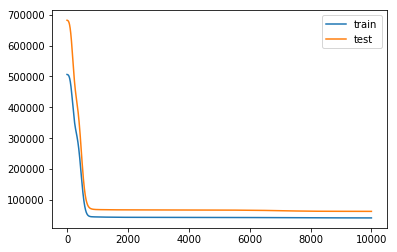

In [150]:
from numpy import concatenate
values = df_final[0].values
train = values[20:69,:]
test = values[23:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
model = Sequential()
model.add(LSTM(2048, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
batch_size=72
history = model.fit(train_X, train_y, epochs=10000, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



     Day    Predicted  Actual
0    0.0    63.060577     4.0
1    1.0    22.249075    11.0
2    2.0    22.076365     4.0
3    3.0    48.041027    11.0
4    4.0     0.124294     4.0
5    5.0    49.140862    11.0
6    6.0   171.962326     4.0
7    7.0   129.918777    15.0
8    8.0   109.617775     7.0
9    9.0    55.769295    15.0
10  10.0    69.934715     7.0
11  11.0    63.060577    15.0
12  12.0    22.249075     7.0
13  13.0   146.732758    16.0
14  14.0   217.643311     7.0
15  15.0   110.315475    18.0
16  16.0   102.971092     9.0
17  17.0    41.725449    21.0
18  18.0    98.757835    18.0
19  19.0    91.208054    34.0
20  20.0    38.034832    21.0
21  21.0    31.206631    39.0
22  22.0    60.503616    24.0
23  23.0    61.958717    52.0
24  24.0   111.316010    39.0
25  25.0   183.988983    68.0
26  26.0   146.732758    60.0
27  27.0   135.916489    68.0
28  28.0   135.916489   132.0
29  29.0   113.179733   118.0
30  30.0   218.490692   179.0
31  31.0   185.822220   198.0
32  32.0  

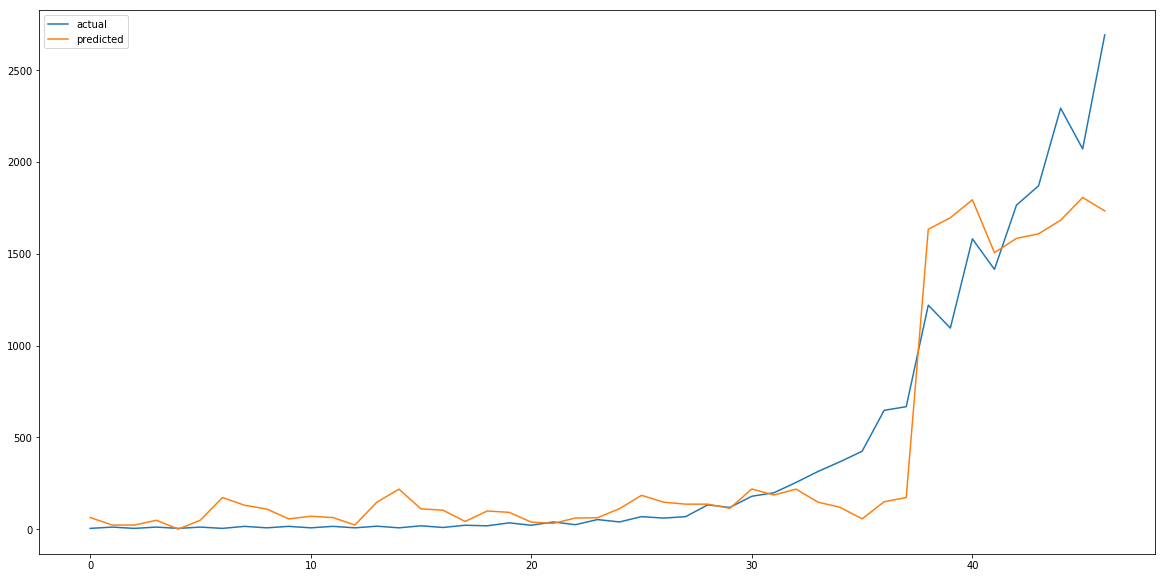

In [151]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas import DataFrame

y_pred = model.predict(test_X, batch_size=batch_size)
i = 0

comparision_data = DataFrame()

for x,y,actual in zip(test_X, y_pred,test_y):
    comparision_data.at[i,'Day']=i
    
    comparision_data.at[i,'Predicted'] = y[0]
    comparision_data.at[i,'Actual'] = actual
    i+=1
print(comparision_data)
plt.figure(figsize=(20,10))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(test_y,label='actual')
plt.plot(y_pred,label='predicted')
plt.legend()
plt.show()
